In [7]:
import requests
from tqdm import tqdm
import gzip
import numpy as np
import matplotlib.pyplot as plt

#### 1.数据处理

In [8]:
def download_file(url, filename):
    """下载文件，并使用进度条显示进度."""
    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    with open(filename, 'wb') as f, tqdm(
            desc=filename,
            total=total_size_in_bytes,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = f.write(data)
            bar.update(size)

def load_mnist_images(filename):
    """从gzip文件中加载MNIST图像数据并进行归一化."""
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 28, 28)
        return data / 255.0

def load_mnist_labels(filename):
    """从gzip文件中加载MNIST标签数据."""
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

def one_hot_encode(labels, num_classes=10):
    """对标签进行独热编码."""
    return np.eye(num_classes)[labels]

# 下载并加载数据
base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
files = ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz", "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]
for file in files:
    download_file(base_url + file, file)

train_images = load_mnist_images('train-images-idx3-ubyte.gz').reshape(-1, 784)  # 展平图像
train_labels_one_hot = one_hot_encode(load_mnist_labels('train-labels-idx1-ubyte.gz'))
test_images = load_mnist_images('t10k-images-idx3-ubyte.gz').reshape(-1, 784)  # 展平图像
test_labels_one_hot = one_hot_encode(load_mnist_labels('t10k-labels-idx1-ubyte.gz'))

train-images-idx3-ubyte.gz: 100%|██████████| 25.2M/25.2M [00:07<00:00, 3.31MiB/s]
train-labels-idx1-ubyte.gz: 100%|██████████| 28.8k/28.8k [00:00<00:00, 103kiB/s] 
t10k-images-idx3-ubyte.gz: 100%|██████████| 4.22M/4.22M [00:02<00:00, 1.85MiB/s]
t10k-labels-idx1-ubyte.gz: 100%|██████████| 5.03k/5.03k [00:00<00:00, 2.47MiB/s]


#### 2. 模型定义

In [9]:
class NeuralNetwork:
    """三层全连接神经网络."""
    def __init__(self, input_size, hidden_size, output_size, activation='relu'):
        # 初始化权重和偏置
        self.params = {
            'W1': np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size),
            'b1': np.zeros((1, hidden_size)),
            'W2': np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size),
            'b2': np.zeros((1, output_size))
        }
        self.activation_name = activation

    def forward(self, X):
        # 前向传播
        Z1 = np.dot(X, self.params['W1']) + self.params['b1']
        A1 = relu(Z1)
        Z2 = np.dot(A1, self.params['W2']) + self.params['b2']
        A2 = softmax(Z2)
        self.cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
        return A2

    def backward(self, X, y_true):
        # 反向传播计算梯度
        m = y_true.shape[0]
        output_error = self.cache['A2'] - y_true
        dW2 = np.dot(self.cache['A1'].T, output_error) / m
        db2 = np.sum(output_error, axis=0, keepdims=True) / m
        hidden_error = np.dot(output_error, self.params['W2'].T) * relu_derivative(self.cache['Z1'])
        dW1 = np.dot(X.T, hidden_error) / m
        db1 = np.sum(hidden_error, axis=0, keepdims=True) / m
        return {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}

    def update_params(self, grads, learning_rate, lambda_reg=0.001):
        # 更新权重和偏置
        for key in ['W1', 'W2']:
            self.params[key] -= learning_rate * (grads[key] + lambda_reg * self.params[key])
        for key in ['b1', 'b2']:
            self.params[key] -= learning_rate * grads[key]

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy(predictions, labels):
    return -np.sum(labels * np.log(predictions + 1e-9)) / predictions.shape[0]

#### 3. 训练和评估

In [10]:
def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, lambda_reg=0.001, lr_decay=0.95):
    # 训练模型，并记录历史数据
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'grad_norms': []}
    best_val_acc = 0
    best_params = {}
    for epoch in range(epochs):
        current_lr = learning_rate * (lr_decay ** epoch)
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        epoch_grads = []
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            outputs = model.forward(X_batch)
            loss = cross_entropy(outputs, y_batch)
            grads = model.backward(X_batch, y_batch)
            model.update_params(grads, current_lr, lambda_reg)
            grad_norm = np.linalg.norm(np.concatenate([grad.flatten() for grad in grads.values()]))
            epoch_grads.append(grad_norm)
        history['grad_norms'].append(np.mean(epoch_grads))
        train_loss, train_acc = evaluate(model, X_train, y_train)
        val_loss, val_acc = evaluate(model, X_val, y_val)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = {k: v.copy() for k, v in model.params.items()}
    model.params = best_params
    return history

def evaluate(model, X, y, batch_size=1024):
    # 评估模型性能
    total_loss = 0
    correct_preds = 0
    total_samples = X.shape[0]
    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        X_batch = X[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]
        outputs = model.forward(X_batch)
        total_loss += cross_entropy(outputs, y_batch) * (end_idx - start_idx)
        predictions = np.argmax(outputs, axis=1)
        labels = np.argmax(y_batch, axis=1)
        correct_preds += np.sum(predictions == labels)
    average_loss = total_loss / total_samples
    accuracy = correct_preds / total_samples
    return average_loss, accuracy

#### 4. 性能可视化

In [18]:
def plot_history_with_params(history, learning_rate, hidden_size, lambda_reg):
    # 绘制训练和验证的损失以及准确率曲线
    plt.figure(figsize=(14, 5))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss (LR={learning_rate}, Hidden={hidden_size}, Lambda={lambda_reg})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy (LR={learning_rate}, Hidden={hidden_size}, Lambda={lambda_reg})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_weights(weights, title="Visualized Weights", figsize=(15, 15)):
    num_hidden_units = weights.shape[1]
    num_plots = min(num_hidden_units, 64)  # 最多可视化64个隐藏单元的权重
    num_cols = 8  # 列数
    num_rows = (num_plots + num_cols - 1) // num_cols  # 计算行数

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_plots):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_plots > 1 else axes
        ax.imshow(weights[:, i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Unit {i+1}')
    plt.suptitle(title)
    plt.show()

Epoch 1/50, Train Loss: 0.6436, Train Acc: 0.7847, Val Loss: 0.6641, Val Acc: 0.7749
Epoch 2/50, Train Loss: 0.5669, Train Acc: 0.8075, Val Loss: 0.5908, Val Acc: 0.7977
Epoch 3/50, Train Loss: 0.5185, Train Acc: 0.8243, Val Loss: 0.5448, Val Acc: 0.8148
Epoch 4/50, Train Loss: 0.4930, Train Acc: 0.8324, Val Loss: 0.5209, Val Acc: 0.8219
Epoch 5/50, Train Loss: 0.4802, Train Acc: 0.8362, Val Loss: 0.5123, Val Acc: 0.8233
Epoch 6/50, Train Loss: 0.4637, Train Acc: 0.8426, Val Loss: 0.4963, Val Acc: 0.8272
Epoch 7/50, Train Loss: 0.4543, Train Acc: 0.8440, Val Loss: 0.4868, Val Acc: 0.8320
Epoch 8/50, Train Loss: 0.4538, Train Acc: 0.8418, Val Loss: 0.4887, Val Acc: 0.8260
Epoch 9/50, Train Loss: 0.4419, Train Acc: 0.8492, Val Loss: 0.4773, Val Acc: 0.8326
Epoch 10/50, Train Loss: 0.4387, Train Acc: 0.8493, Val Loss: 0.4735, Val Acc: 0.8346
Epoch 11/50, Train Loss: 0.4295, Train Acc: 0.8528, Val Loss: 0.4649, Val Acc: 0.8378
Epoch 12/50, Train Loss: 0.4268, Train Acc: 0.8541, Val Loss: 0

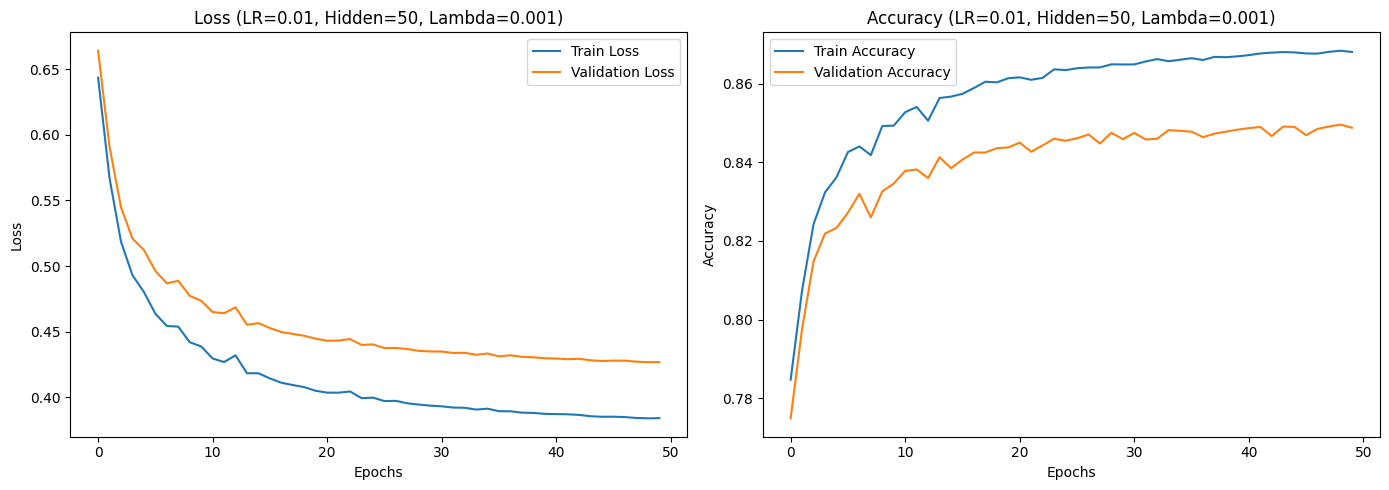

LR: 0.01, Hidden: 50, Lambda: 0.001, Best Val Acc: 0.8496
Epoch 1/50, Train Loss: 0.6607, Train Acc: 0.7892, Val Loss: 0.6777, Val Acc: 0.7788
Epoch 2/50, Train Loss: 0.5852, Train Acc: 0.8069, Val Loss: 0.6053, Val Acc: 0.7983
Epoch 3/50, Train Loss: 0.5394, Train Acc: 0.8240, Val Loss: 0.5620, Val Acc: 0.8141
Epoch 4/50, Train Loss: 0.5252, Train Acc: 0.8289, Val Loss: 0.5485, Val Acc: 0.8187
Epoch 5/50, Train Loss: 0.5105, Train Acc: 0.8321, Val Loss: 0.5355, Val Acc: 0.8195
Epoch 6/50, Train Loss: 0.5012, Train Acc: 0.8352, Val Loss: 0.5265, Val Acc: 0.8226
Epoch 7/50, Train Loss: 0.4966, Train Acc: 0.8382, Val Loss: 0.5229, Val Acc: 0.8245
Epoch 8/50, Train Loss: 0.4911, Train Acc: 0.8394, Val Loss: 0.5166, Val Acc: 0.8281
Epoch 9/50, Train Loss: 0.4863, Train Acc: 0.8411, Val Loss: 0.5122, Val Acc: 0.8291
Epoch 10/50, Train Loss: 0.4849, Train Acc: 0.8420, Val Loss: 0.5104, Val Acc: 0.8297
Epoch 11/50, Train Loss: 0.4810, Train Acc: 0.8425, Val Loss: 0.5071, Val Acc: 0.8295
Epoch

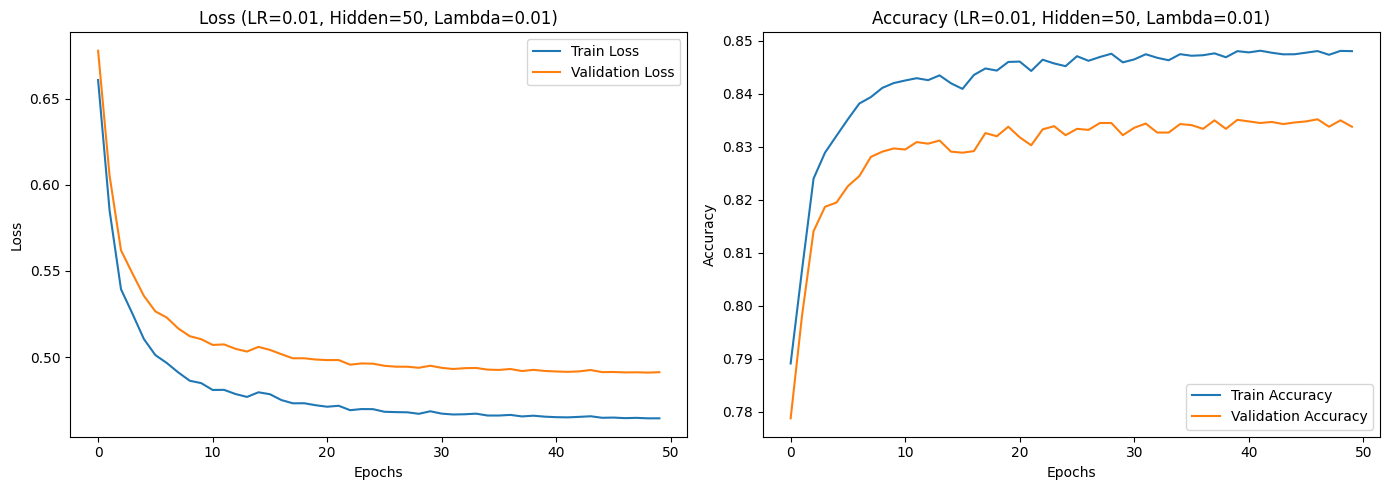

LR: 0.01, Hidden: 50, Lambda: 0.01, Best Val Acc: 0.8352
Epoch 1/50, Train Loss: 0.9264, Train Acc: 0.7338, Val Loss: 0.9395, Val Acc: 0.7225
Epoch 2/50, Train Loss: 0.9157, Train Acc: 0.7346, Val Loss: 0.9283, Val Acc: 0.7262
Epoch 3/50, Train Loss: 0.9083, Train Acc: 0.7433, Val Loss: 0.9203, Val Acc: 0.7351
Epoch 4/50, Train Loss: 0.9029, Train Acc: 0.7461, Val Loss: 0.9146, Val Acc: 0.7361
Epoch 5/50, Train Loss: 0.9015, Train Acc: 0.7339, Val Loss: 0.9134, Val Acc: 0.7247
Epoch 6/50, Train Loss: 0.8977, Train Acc: 0.7435, Val Loss: 0.9092, Val Acc: 0.7341
Epoch 7/50, Train Loss: 0.8978, Train Acc: 0.7307, Val Loss: 0.9093, Val Acc: 0.7224
Epoch 8/50, Train Loss: 0.8933, Train Acc: 0.7469, Val Loss: 0.9042, Val Acc: 0.7381
Epoch 9/50, Train Loss: 0.8918, Train Acc: 0.7423, Val Loss: 0.9031, Val Acc: 0.7366
Epoch 10/50, Train Loss: 0.8900, Train Acc: 0.7419, Val Loss: 0.9013, Val Acc: 0.7348
Epoch 11/50, Train Loss: 0.8875, Train Acc: 0.7410, Val Loss: 0.8982, Val Acc: 0.7344
Epoch 

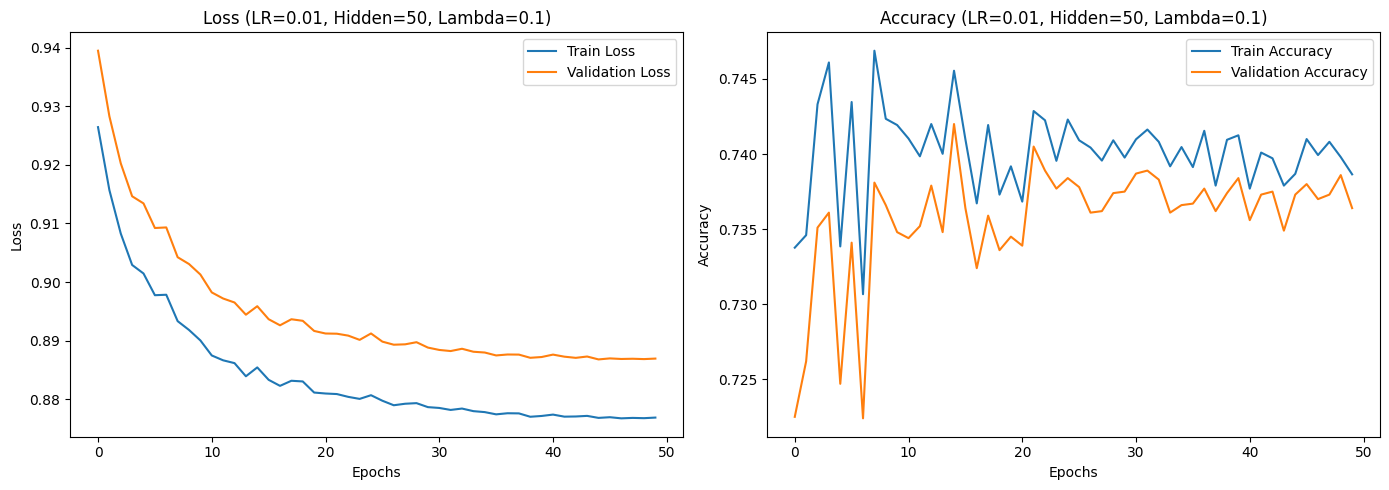

LR: 0.01, Hidden: 50, Lambda: 0.1, Best Val Acc: 0.742
Epoch 1/50, Train Loss: 0.6412, Train Acc: 0.7827, Val Loss: 0.6606, Val Acc: 0.7723
Epoch 2/50, Train Loss: 0.5476, Train Acc: 0.8166, Val Loss: 0.5731, Val Acc: 0.8021
Epoch 3/50, Train Loss: 0.5075, Train Acc: 0.8275, Val Loss: 0.5348, Val Acc: 0.8170
Epoch 4/50, Train Loss: 0.4926, Train Acc: 0.8320, Val Loss: 0.5211, Val Acc: 0.8218
Epoch 5/50, Train Loss: 0.4679, Train Acc: 0.8405, Val Loss: 0.4994, Val Acc: 0.8274
Epoch 6/50, Train Loss: 0.4589, Train Acc: 0.8420, Val Loss: 0.4911, Val Acc: 0.8294
Epoch 7/50, Train Loss: 0.4538, Train Acc: 0.8436, Val Loss: 0.4880, Val Acc: 0.8271
Epoch 8/50, Train Loss: 0.4384, Train Acc: 0.8492, Val Loss: 0.4717, Val Acc: 0.8344
Epoch 9/50, Train Loss: 0.4351, Train Acc: 0.8502, Val Loss: 0.4696, Val Acc: 0.8342
Epoch 10/50, Train Loss: 0.4289, Train Acc: 0.8520, Val Loss: 0.4648, Val Acc: 0.8348
Epoch 11/50, Train Loss: 0.4207, Train Acc: 0.8565, Val Loss: 0.4563, Val Acc: 0.8407
Epoch 12

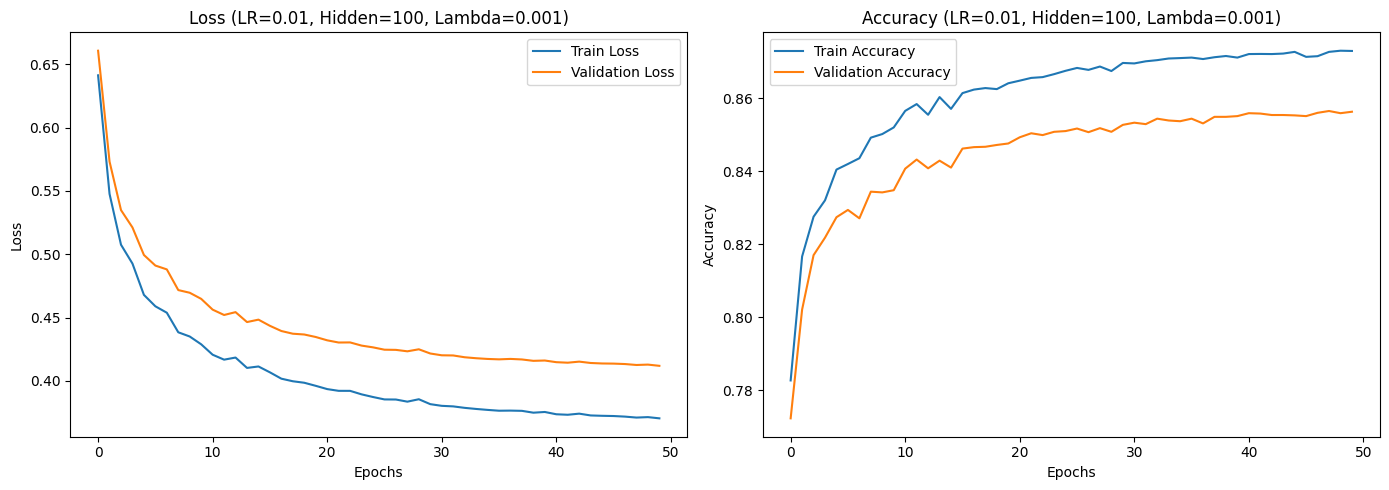

LR: 0.01, Hidden: 100, Lambda: 0.001, Best Val Acc: 0.8565
Epoch 1/50, Train Loss: 0.6694, Train Acc: 0.7799, Val Loss: 0.6866, Val Acc: 0.7683
Epoch 2/50, Train Loss: 0.5836, Train Acc: 0.8114, Val Loss: 0.6059, Val Acc: 0.7990
Epoch 3/50, Train Loss: 0.5544, Train Acc: 0.8196, Val Loss: 0.5763, Val Acc: 0.8073
Epoch 4/50, Train Loss: 0.5245, Train Acc: 0.8288, Val Loss: 0.5486, Val Acc: 0.8166
Epoch 5/50, Train Loss: 0.5182, Train Acc: 0.8277, Val Loss: 0.5436, Val Acc: 0.8163
Epoch 6/50, Train Loss: 0.5154, Train Acc: 0.8269, Val Loss: 0.5412, Val Acc: 0.8140
Epoch 7/50, Train Loss: 0.4989, Train Acc: 0.8358, Val Loss: 0.5239, Val Acc: 0.8230
Epoch 8/50, Train Loss: 0.4964, Train Acc: 0.8370, Val Loss: 0.5226, Val Acc: 0.8234
Epoch 9/50, Train Loss: 0.4933, Train Acc: 0.8366, Val Loss: 0.5204, Val Acc: 0.8225
Epoch 10/50, Train Loss: 0.4912, Train Acc: 0.8370, Val Loss: 0.5168, Val Acc: 0.8237
Epoch 11/50, Train Loss: 0.4846, Train Acc: 0.8406, Val Loss: 0.5105, Val Acc: 0.8280
Epoc

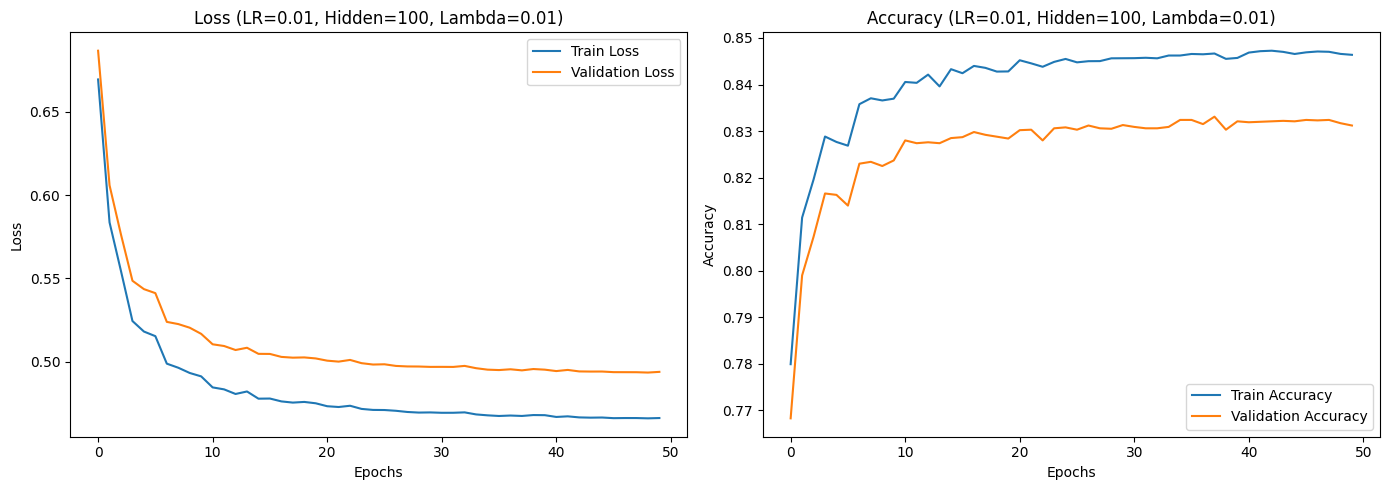

LR: 0.01, Hidden: 100, Lambda: 0.01, Best Val Acc: 0.8331
Epoch 1/50, Train Loss: 0.9103, Train Acc: 0.7420, Val Loss: 0.9239, Val Acc: 0.7302
Epoch 2/50, Train Loss: 0.9118, Train Acc: 0.7346, Val Loss: 0.9247, Val Acc: 0.7226
Epoch 3/50, Train Loss: 0.9074, Train Acc: 0.7424, Val Loss: 0.9190, Val Acc: 0.7324
Epoch 4/50, Train Loss: 0.9022, Train Acc: 0.7461, Val Loss: 0.9138, Val Acc: 0.7361
Epoch 5/50, Train Loss: 0.9010, Train Acc: 0.7437, Val Loss: 0.9127, Val Acc: 0.7339
Epoch 6/50, Train Loss: 0.8962, Train Acc: 0.7480, Val Loss: 0.9072, Val Acc: 0.7399
Epoch 7/50, Train Loss: 0.8957, Train Acc: 0.7486, Val Loss: 0.9069, Val Acc: 0.7423
Epoch 8/50, Train Loss: 0.8920, Train Acc: 0.7460, Val Loss: 0.9030, Val Acc: 0.7391
Epoch 9/50, Train Loss: 0.8912, Train Acc: 0.7452, Val Loss: 0.9024, Val Acc: 0.7402
Epoch 10/50, Train Loss: 0.8909, Train Acc: 0.7430, Val Loss: 0.9010, Val Acc: 0.7368
Epoch 11/50, Train Loss: 0.8886, Train Acc: 0.7437, Val Loss: 0.8991, Val Acc: 0.7389
Epoch

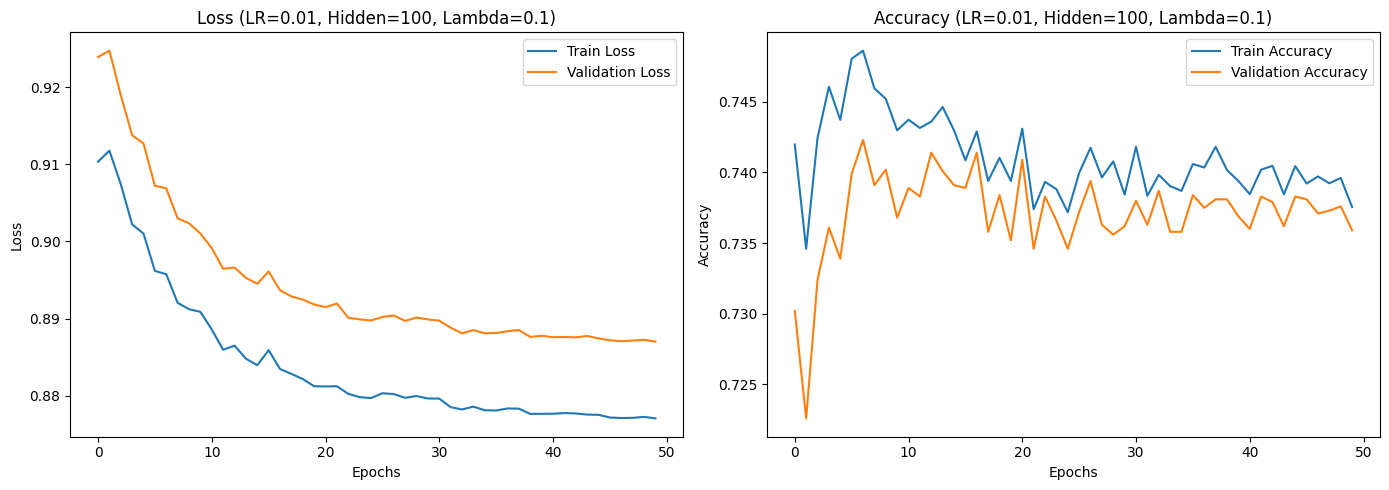

LR: 0.01, Hidden: 100, Lambda: 0.1, Best Val Acc: 0.7423
Epoch 1/50, Train Loss: 0.6368, Train Acc: 0.7951, Val Loss: 0.6584, Val Acc: 0.7810
Epoch 2/50, Train Loss: 0.5466, Train Acc: 0.8197, Val Loss: 0.5722, Val Acc: 0.8077
Epoch 3/50, Train Loss: 0.5145, Train Acc: 0.8251, Val Loss: 0.5407, Val Acc: 0.8126
Epoch 4/50, Train Loss: 0.4847, Train Acc: 0.8346, Val Loss: 0.5146, Val Acc: 0.8241
Epoch 5/50, Train Loss: 0.4649, Train Acc: 0.8420, Val Loss: 0.4954, Val Acc: 0.8291
Epoch 6/50, Train Loss: 0.4564, Train Acc: 0.8436, Val Loss: 0.4874, Val Acc: 0.8318
Epoch 7/50, Train Loss: 0.4444, Train Acc: 0.8484, Val Loss: 0.4760, Val Acc: 0.8356
Epoch 8/50, Train Loss: 0.4426, Train Acc: 0.8479, Val Loss: 0.4762, Val Acc: 0.8323
Epoch 9/50, Train Loss: 0.4315, Train Acc: 0.8525, Val Loss: 0.4650, Val Acc: 0.8376
Epoch 10/50, Train Loss: 0.4250, Train Acc: 0.8537, Val Loss: 0.4592, Val Acc: 0.8403
Epoch 11/50, Train Loss: 0.4228, Train Acc: 0.8547, Val Loss: 0.4575, Val Acc: 0.8407
Epoch 

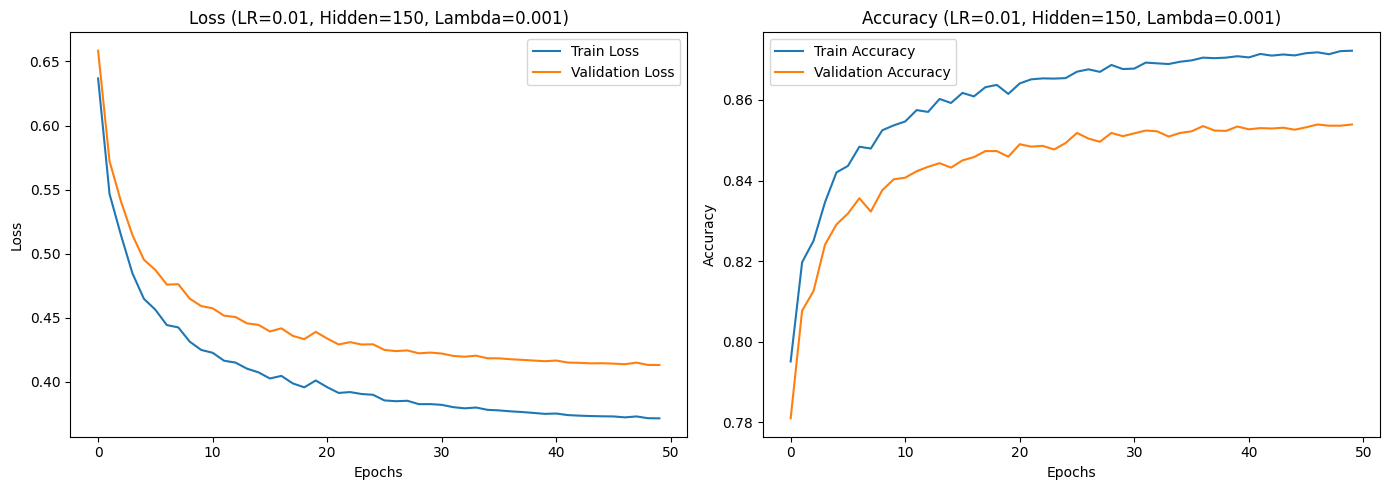

LR: 0.01, Hidden: 150, Lambda: 0.001, Best Val Acc: 0.8539
Epoch 1/50, Train Loss: 0.6590, Train Acc: 0.7878, Val Loss: 0.6766, Val Acc: 0.7809
Epoch 2/50, Train Loss: 0.5740, Train Acc: 0.8120, Val Loss: 0.5957, Val Acc: 0.8024
Epoch 3/50, Train Loss: 0.5368, Train Acc: 0.8258, Val Loss: 0.5601, Val Acc: 0.8159
Epoch 4/50, Train Loss: 0.5177, Train Acc: 0.8307, Val Loss: 0.5430, Val Acc: 0.8213
Epoch 5/50, Train Loss: 0.5080, Train Acc: 0.8350, Val Loss: 0.5336, Val Acc: 0.8218
Epoch 6/50, Train Loss: 0.5048, Train Acc: 0.8320, Val Loss: 0.5319, Val Acc: 0.8181
Epoch 7/50, Train Loss: 0.4956, Train Acc: 0.8377, Val Loss: 0.5223, Val Acc: 0.8226
Epoch 8/50, Train Loss: 0.4890, Train Acc: 0.8394, Val Loss: 0.5148, Val Acc: 0.8275
Epoch 9/50, Train Loss: 0.4853, Train Acc: 0.8416, Val Loss: 0.5120, Val Acc: 0.8277
Epoch 10/50, Train Loss: 0.4845, Train Acc: 0.8406, Val Loss: 0.5115, Val Acc: 0.8292
Epoch 11/50, Train Loss: 0.4796, Train Acc: 0.8435, Val Loss: 0.5065, Val Acc: 0.8304
Epoc

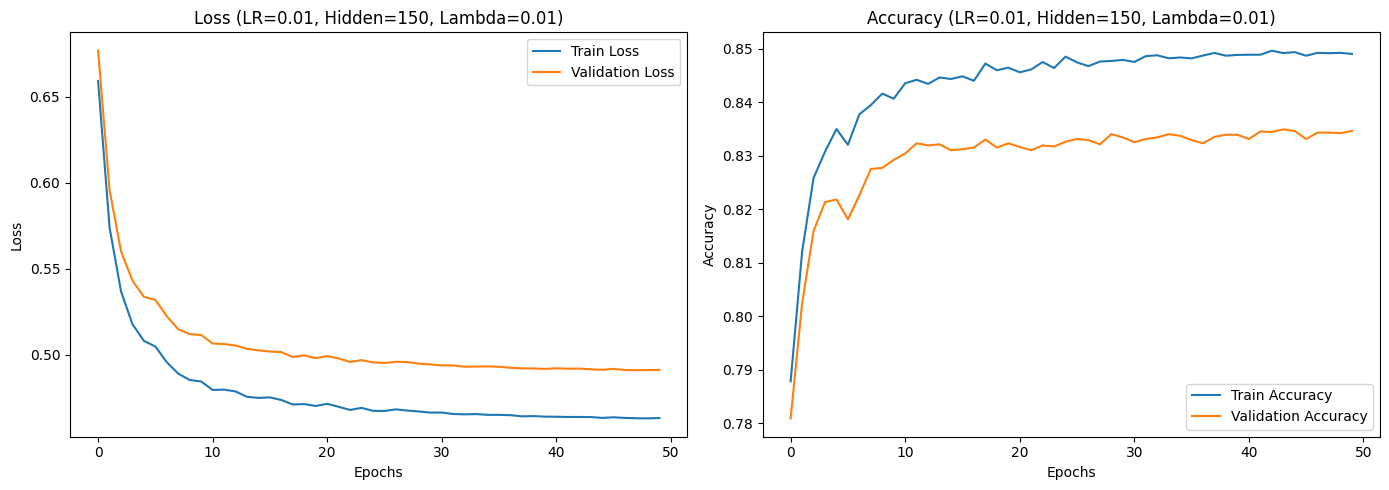

LR: 0.01, Hidden: 150, Lambda: 0.01, Best Val Acc: 0.8349
Epoch 1/50, Train Loss: 0.9156, Train Acc: 0.7361, Val Loss: 0.9272, Val Acc: 0.7253
Epoch 2/50, Train Loss: 0.9136, Train Acc: 0.7431, Val Loss: 0.9257, Val Acc: 0.7305
Epoch 3/50, Train Loss: 0.9077, Train Acc: 0.7411, Val Loss: 0.9195, Val Acc: 0.7304
Epoch 4/50, Train Loss: 0.9024, Train Acc: 0.7437, Val Loss: 0.9139, Val Acc: 0.7348
Epoch 5/50, Train Loss: 0.8992, Train Acc: 0.7508, Val Loss: 0.9108, Val Acc: 0.7388
Epoch 6/50, Train Loss: 0.8958, Train Acc: 0.7475, Val Loss: 0.9067, Val Acc: 0.7380
Epoch 7/50, Train Loss: 0.8941, Train Acc: 0.7437, Val Loss: 0.9055, Val Acc: 0.7355
Epoch 8/50, Train Loss: 0.8909, Train Acc: 0.7478, Val Loss: 0.9020, Val Acc: 0.7400
Epoch 9/50, Train Loss: 0.8900, Train Acc: 0.7484, Val Loss: 0.9009, Val Acc: 0.7429
Epoch 10/50, Train Loss: 0.8873, Train Acc: 0.7430, Val Loss: 0.8982, Val Acc: 0.7371
Epoch 11/50, Train Loss: 0.8890, Train Acc: 0.7421, Val Loss: 0.9003, Val Acc: 0.7357
Epoch

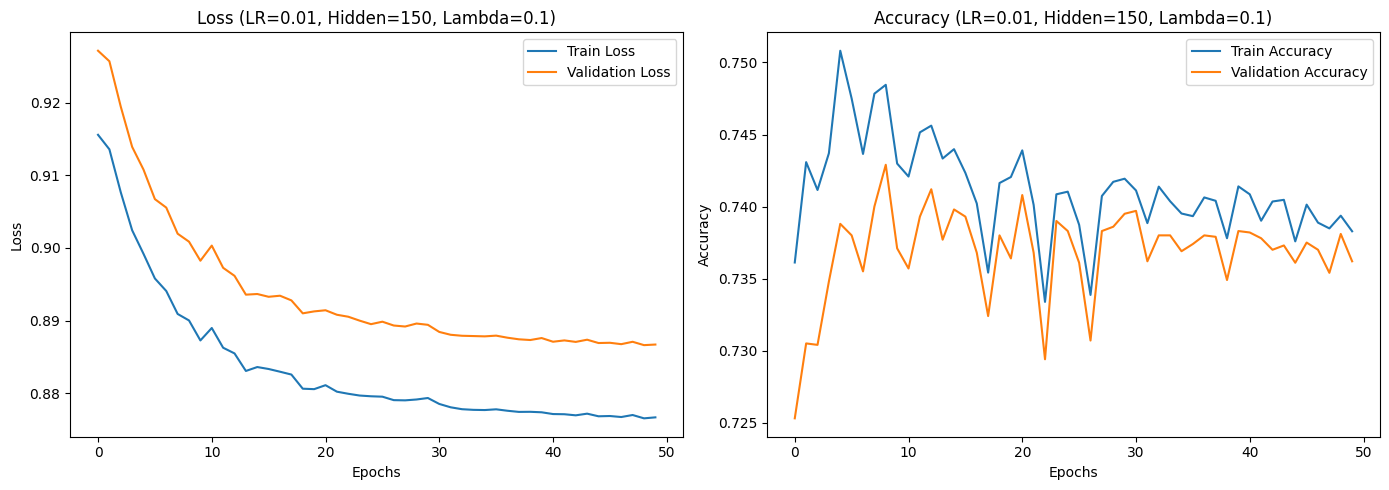

LR: 0.01, Hidden: 150, Lambda: 0.1, Best Val Acc: 0.7429
Epoch 1/50, Train Loss: 0.7462, Train Acc: 0.7610, Val Loss: 0.7648, Val Acc: 0.7467
Epoch 2/50, Train Loss: 0.6275, Train Acc: 0.7945, Val Loss: 0.6491, Val Acc: 0.7835
Epoch 3/50, Train Loss: 0.5782, Train Acc: 0.8075, Val Loss: 0.6014, Val Acc: 0.7967
Epoch 4/50, Train Loss: 0.5434, Train Acc: 0.8192, Val Loss: 0.5698, Val Acc: 0.8063
Epoch 5/50, Train Loss: 0.5245, Train Acc: 0.8241, Val Loss: 0.5529, Val Acc: 0.8117
Epoch 6/50, Train Loss: 0.5082, Train Acc: 0.8300, Val Loss: 0.5374, Val Acc: 0.8182
Epoch 7/50, Train Loss: 0.4977, Train Acc: 0.8331, Val Loss: 0.5277, Val Acc: 0.8215
Epoch 8/50, Train Loss: 0.4881, Train Acc: 0.8357, Val Loss: 0.5187, Val Acc: 0.8243
Epoch 9/50, Train Loss: 0.4816, Train Acc: 0.8370, Val Loss: 0.5125, Val Acc: 0.8238
Epoch 10/50, Train Loss: 0.4788, Train Acc: 0.8370, Val Loss: 0.5097, Val Acc: 0.8252
Epoch 11/50, Train Loss: 0.4734, Train Acc: 0.8394, Val Loss: 0.5067, Val Acc: 0.8268
Epoch 

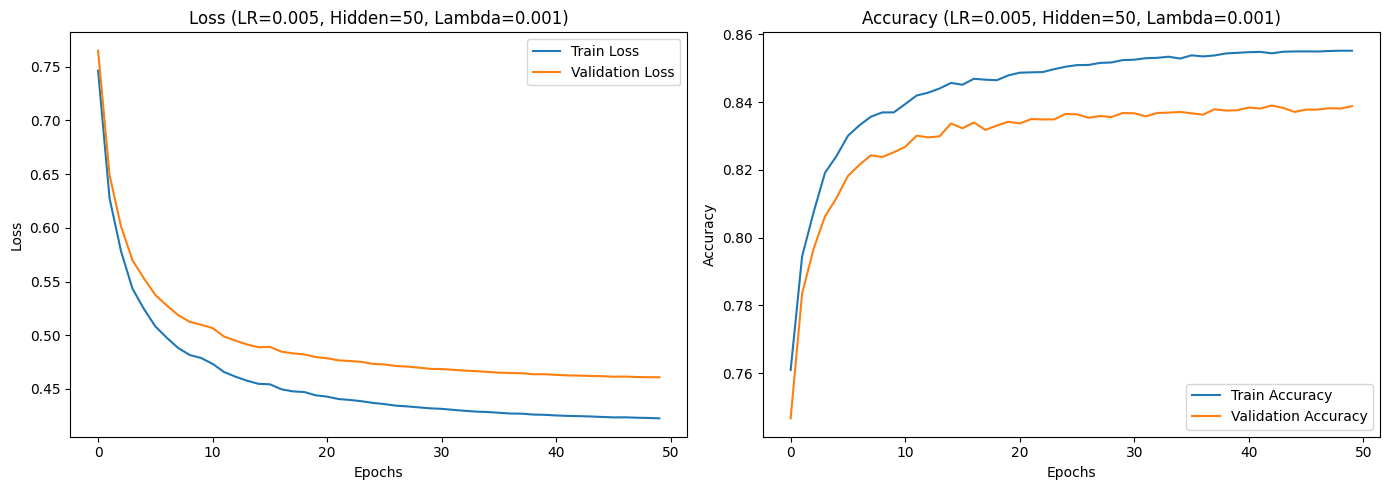

LR: 0.005, Hidden: 50, Lambda: 0.001, Best Val Acc: 0.839
Epoch 1/50, Train Loss: 0.7915, Train Acc: 0.7422, Val Loss: 0.8078, Val Acc: 0.7296
Epoch 2/50, Train Loss: 0.6685, Train Acc: 0.7855, Val Loss: 0.6880, Val Acc: 0.7714
Epoch 3/50, Train Loss: 0.6138, Train Acc: 0.8057, Val Loss: 0.6346, Val Acc: 0.7936
Epoch 4/50, Train Loss: 0.5827, Train Acc: 0.8137, Val Loss: 0.6042, Val Acc: 0.8002
Epoch 5/50, Train Loss: 0.5606, Train Acc: 0.8194, Val Loss: 0.5838, Val Acc: 0.8071
Epoch 6/50, Train Loss: 0.5455, Train Acc: 0.8237, Val Loss: 0.5694, Val Acc: 0.8100
Epoch 7/50, Train Loss: 0.5354, Train Acc: 0.8266, Val Loss: 0.5603, Val Acc: 0.8128
Epoch 8/50, Train Loss: 0.5267, Train Acc: 0.8290, Val Loss: 0.5514, Val Acc: 0.8150
Epoch 9/50, Train Loss: 0.5216, Train Acc: 0.8308, Val Loss: 0.5463, Val Acc: 0.8178
Epoch 10/50, Train Loss: 0.5151, Train Acc: 0.8336, Val Loss: 0.5404, Val Acc: 0.8209
Epoch 11/50, Train Loss: 0.5110, Train Acc: 0.8345, Val Loss: 0.5363, Val Acc: 0.8215
Epoch

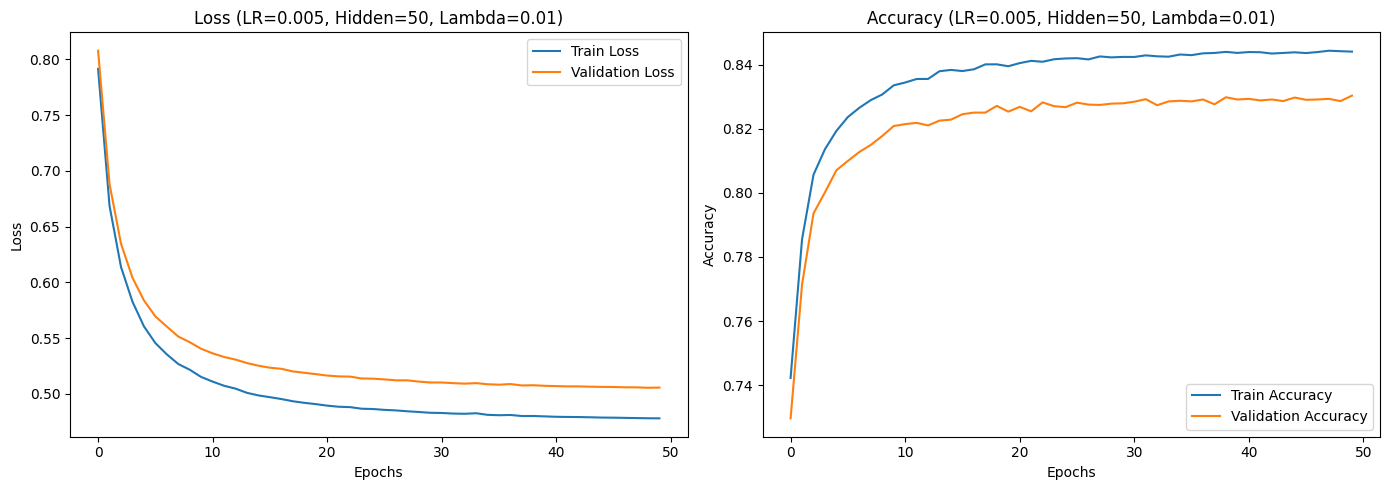

LR: 0.005, Hidden: 50, Lambda: 0.01, Best Val Acc: 0.8304
Epoch 1/50, Train Loss: 0.9661, Train Acc: 0.7035, Val Loss: 0.9763, Val Acc: 0.6923
Epoch 2/50, Train Loss: 0.9259, Train Acc: 0.7298, Val Loss: 0.9374, Val Acc: 0.7191
Epoch 3/50, Train Loss: 0.9188, Train Acc: 0.7341, Val Loss: 0.9301, Val Acc: 0.7238
Epoch 4/50, Train Loss: 0.9169, Train Acc: 0.7446, Val Loss: 0.9285, Val Acc: 0.7327
Epoch 5/50, Train Loss: 0.9150, Train Acc: 0.7463, Val Loss: 0.9259, Val Acc: 0.7355
Epoch 6/50, Train Loss: 0.9109, Train Acc: 0.7415, Val Loss: 0.9226, Val Acc: 0.7318
Epoch 7/50, Train Loss: 0.9080, Train Acc: 0.7447, Val Loss: 0.9193, Val Acc: 0.7353
Epoch 8/50, Train Loss: 0.9071, Train Acc: 0.7476, Val Loss: 0.9181, Val Acc: 0.7363
Epoch 9/50, Train Loss: 0.9049, Train Acc: 0.7397, Val Loss: 0.9163, Val Acc: 0.7318
Epoch 10/50, Train Loss: 0.9030, Train Acc: 0.7458, Val Loss: 0.9141, Val Acc: 0.7380
Epoch 11/50, Train Loss: 0.9018, Train Acc: 0.7497, Val Loss: 0.9129, Val Acc: 0.7405
Epoch

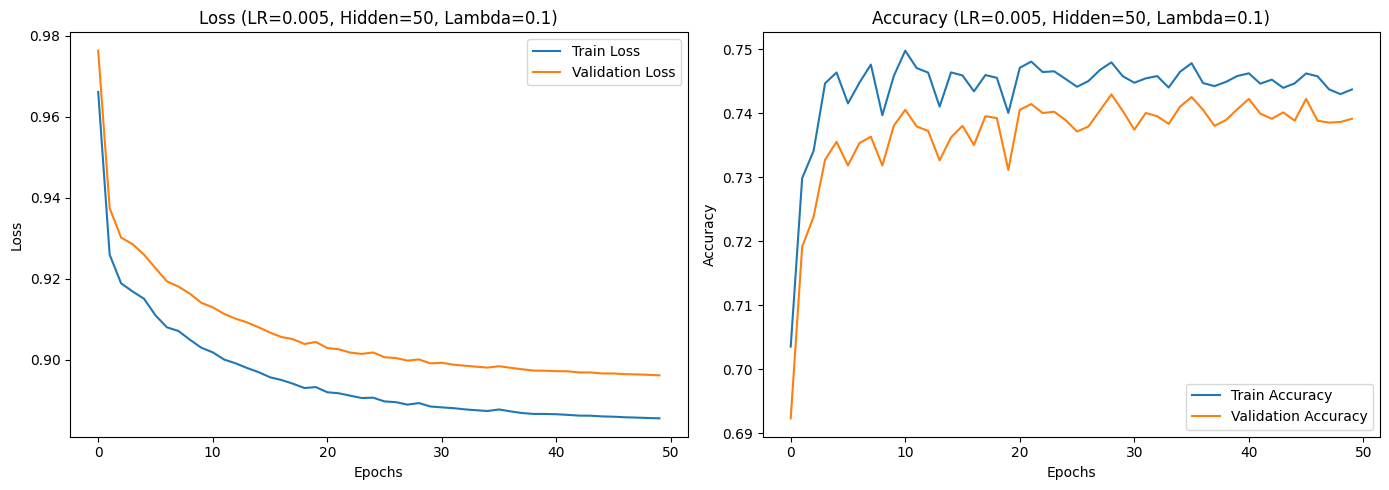

LR: 0.005, Hidden: 50, Lambda: 0.1, Best Val Acc: 0.7429
Epoch 1/50, Train Loss: 0.7734, Train Acc: 0.7472, Val Loss: 0.7913, Val Acc: 0.7340
Epoch 2/50, Train Loss: 0.6486, Train Acc: 0.7900, Val Loss: 0.6700, Val Acc: 0.7781
Epoch 3/50, Train Loss: 0.5940, Train Acc: 0.8038, Val Loss: 0.6169, Val Acc: 0.7904
Epoch 4/50, Train Loss: 0.5589, Train Acc: 0.8162, Val Loss: 0.5842, Val Acc: 0.8035
Epoch 5/50, Train Loss: 0.5361, Train Acc: 0.8229, Val Loss: 0.5625, Val Acc: 0.8084
Epoch 6/50, Train Loss: 0.5216, Train Acc: 0.8261, Val Loss: 0.5495, Val Acc: 0.8126
Epoch 7/50, Train Loss: 0.5063, Train Acc: 0.8312, Val Loss: 0.5346, Val Acc: 0.8172
Epoch 8/50, Train Loss: 0.4971, Train Acc: 0.8334, Val Loss: 0.5260, Val Acc: 0.8198
Epoch 9/50, Train Loss: 0.4886, Train Acc: 0.8356, Val Loss: 0.5184, Val Acc: 0.8220
Epoch 10/50, Train Loss: 0.4821, Train Acc: 0.8383, Val Loss: 0.5134, Val Acc: 0.8239
Epoch 11/50, Train Loss: 0.4751, Train Acc: 0.8405, Val Loss: 0.5064, Val Acc: 0.8256
Epoch 

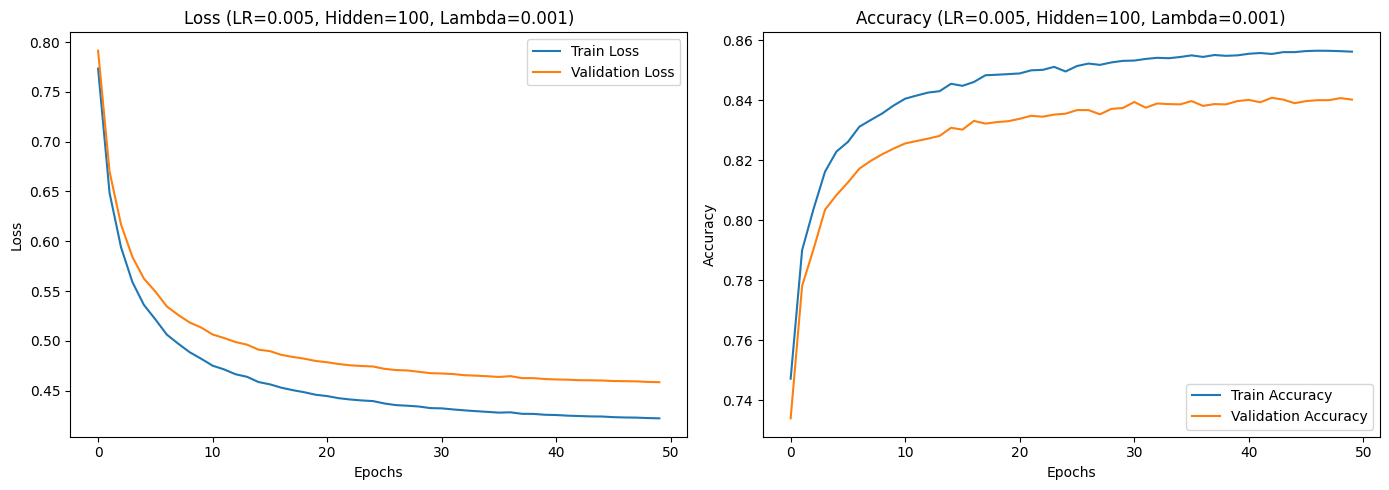

LR: 0.005, Hidden: 100, Lambda: 0.001, Best Val Acc: 0.8408
Epoch 1/50, Train Loss: 0.7822, Train Acc: 0.7478, Val Loss: 0.7976, Val Acc: 0.7305
Epoch 2/50, Train Loss: 0.6638, Train Acc: 0.7858, Val Loss: 0.6812, Val Acc: 0.7718
Epoch 3/50, Train Loss: 0.6118, Train Acc: 0.8030, Val Loss: 0.6304, Val Acc: 0.7886
Epoch 4/50, Train Loss: 0.5815, Train Acc: 0.8125, Val Loss: 0.6004, Val Acc: 0.8007
Epoch 5/50, Train Loss: 0.5606, Train Acc: 0.8189, Val Loss: 0.5821, Val Acc: 0.8062
Epoch 6/50, Train Loss: 0.5466, Train Acc: 0.8218, Val Loss: 0.5685, Val Acc: 0.8102
Epoch 7/50, Train Loss: 0.5369, Train Acc: 0.8262, Val Loss: 0.5598, Val Acc: 0.8146
Epoch 8/50, Train Loss: 0.5266, Train Acc: 0.8290, Val Loss: 0.5494, Val Acc: 0.8196
Epoch 9/50, Train Loss: 0.5207, Train Acc: 0.8309, Val Loss: 0.5429, Val Acc: 0.8202
Epoch 10/50, Train Loss: 0.5174, Train Acc: 0.8312, Val Loss: 0.5407, Val Acc: 0.8217
Epoch 11/50, Train Loss: 0.5125, Train Acc: 0.8342, Val Loss: 0.5354, Val Acc: 0.8231
Epo

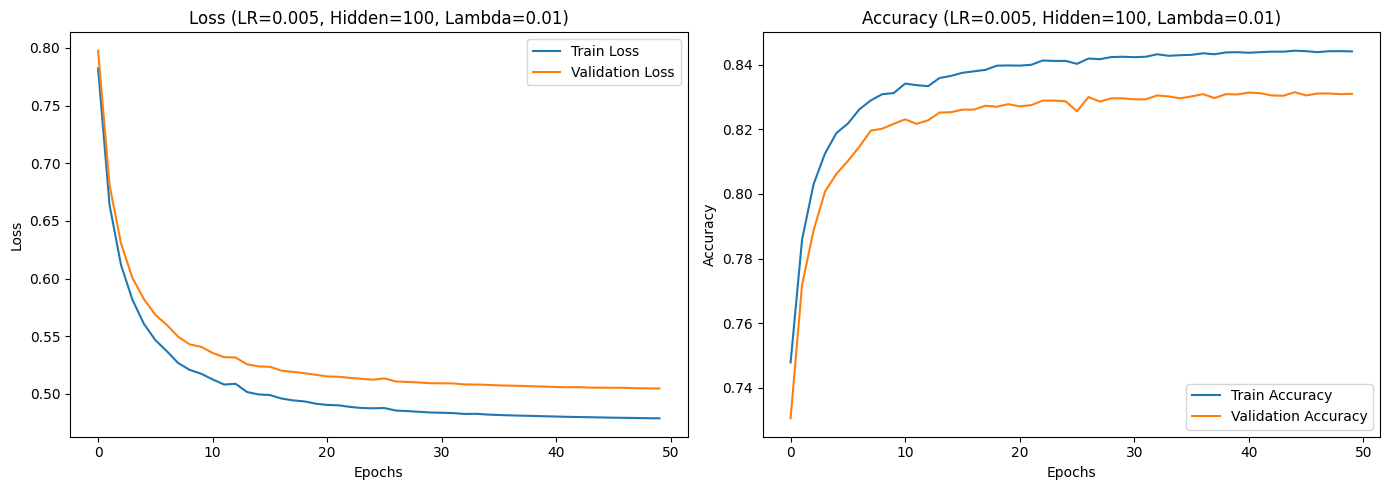

LR: 0.005, Hidden: 100, Lambda: 0.01, Best Val Acc: 0.8315
Epoch 1/50, Train Loss: 0.9183, Train Acc: 0.7422, Val Loss: 0.9307, Val Acc: 0.7316
Epoch 2/50, Train Loss: 0.8942, Train Acc: 0.7451, Val Loss: 0.9065, Val Acc: 0.7334
Epoch 3/50, Train Loss: 0.8955, Train Acc: 0.7518, Val Loss: 0.9078, Val Acc: 0.7398
Epoch 4/50, Train Loss: 0.8992, Train Acc: 0.7548, Val Loss: 0.9112, Val Acc: 0.7446
Epoch 5/50, Train Loss: 0.8995, Train Acc: 0.7514, Val Loss: 0.9117, Val Acc: 0.7397
Epoch 6/50, Train Loss: 0.8994, Train Acc: 0.7510, Val Loss: 0.9111, Val Acc: 0.7399
Epoch 7/50, Train Loss: 0.8991, Train Acc: 0.7468, Val Loss: 0.9106, Val Acc: 0.7371
Epoch 8/50, Train Loss: 0.8983, Train Acc: 0.7535, Val Loss: 0.9098, Val Acc: 0.7435
Epoch 9/50, Train Loss: 0.8980, Train Acc: 0.7519, Val Loss: 0.9091, Val Acc: 0.7417
Epoch 10/50, Train Loss: 0.8963, Train Acc: 0.7487, Val Loss: 0.9075, Val Acc: 0.7405
Epoch 11/50, Train Loss: 0.8961, Train Acc: 0.7496, Val Loss: 0.9070, Val Acc: 0.7424
Epoc

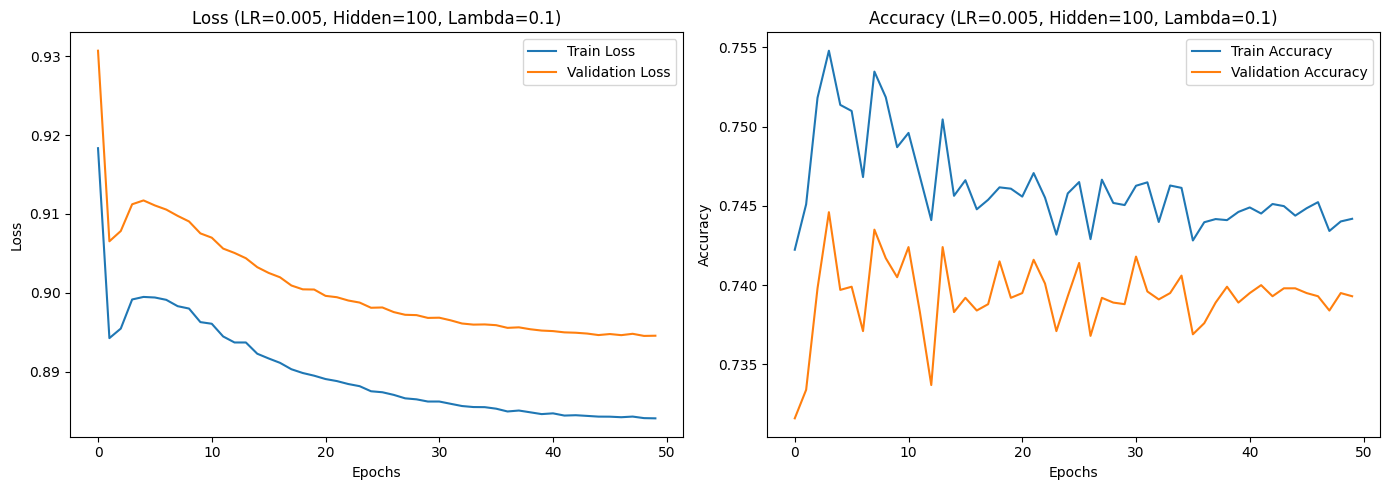

LR: 0.005, Hidden: 100, Lambda: 0.1, Best Val Acc: 0.7446
Epoch 1/50, Train Loss: 0.7644, Train Acc: 0.7524, Val Loss: 0.7815, Val Acc: 0.7364
Epoch 2/50, Train Loss: 0.6405, Train Acc: 0.7933, Val Loss: 0.6624, Val Acc: 0.7767
Epoch 3/50, Train Loss: 0.5834, Train Acc: 0.8100, Val Loss: 0.6069, Val Acc: 0.7945
Epoch 4/50, Train Loss: 0.5537, Train Acc: 0.8173, Val Loss: 0.5801, Val Acc: 0.8035
Epoch 5/50, Train Loss: 0.5281, Train Acc: 0.8249, Val Loss: 0.5542, Val Acc: 0.8136
Epoch 6/50, Train Loss: 0.5137, Train Acc: 0.8303, Val Loss: 0.5409, Val Acc: 0.8172
Epoch 7/50, Train Loss: 0.4996, Train Acc: 0.8331, Val Loss: 0.5272, Val Acc: 0.8225
Epoch 8/50, Train Loss: 0.4894, Train Acc: 0.8357, Val Loss: 0.5181, Val Acc: 0.8244
Epoch 9/50, Train Loss: 0.4826, Train Acc: 0.8369, Val Loss: 0.5113, Val Acc: 0.8254
Epoch 10/50, Train Loss: 0.4759, Train Acc: 0.8399, Val Loss: 0.5049, Val Acc: 0.8275
Epoch 11/50, Train Loss: 0.4688, Train Acc: 0.8421, Val Loss: 0.4986, Val Acc: 0.8284
Epoch

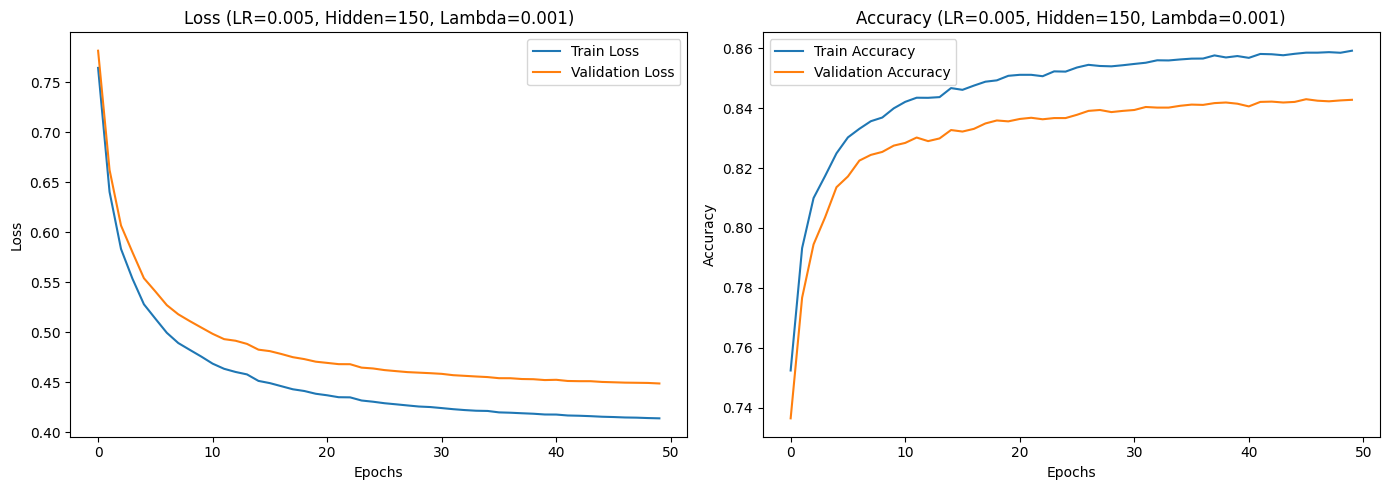

LR: 0.005, Hidden: 150, Lambda: 0.001, Best Val Acc: 0.843
Epoch 1/50, Train Loss: 0.7746, Train Acc: 0.7552, Val Loss: 0.7911, Val Acc: 0.7428
Epoch 2/50, Train Loss: 0.6571, Train Acc: 0.7929, Val Loss: 0.6768, Val Acc: 0.7777
Epoch 3/50, Train Loss: 0.6064, Train Acc: 0.8084, Val Loss: 0.6278, Val Acc: 0.7941
Epoch 4/50, Train Loss: 0.5778, Train Acc: 0.8148, Val Loss: 0.5993, Val Acc: 0.8009
Epoch 5/50, Train Loss: 0.5581, Train Acc: 0.8199, Val Loss: 0.5818, Val Acc: 0.8036
Epoch 6/50, Train Loss: 0.5437, Train Acc: 0.8236, Val Loss: 0.5676, Val Acc: 0.8105
Epoch 7/50, Train Loss: 0.5317, Train Acc: 0.8276, Val Loss: 0.5556, Val Acc: 0.8157
Epoch 8/50, Train Loss: 0.5264, Train Acc: 0.8283, Val Loss: 0.5515, Val Acc: 0.8147
Epoch 9/50, Train Loss: 0.5182, Train Acc: 0.8329, Val Loss: 0.5430, Val Acc: 0.8202
Epoch 10/50, Train Loss: 0.5135, Train Acc: 0.8336, Val Loss: 0.5385, Val Acc: 0.8209
Epoch 11/50, Train Loss: 0.5101, Train Acc: 0.8343, Val Loss: 0.5351, Val Acc: 0.8220
Epoc

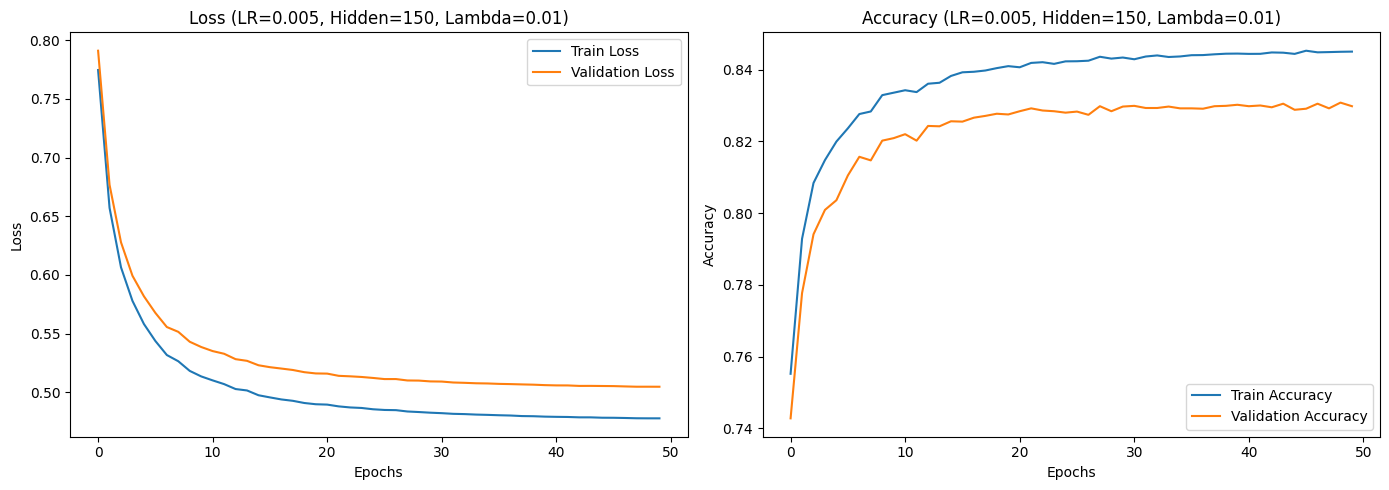

LR: 0.005, Hidden: 150, Lambda: 0.01, Best Val Acc: 0.8308
Epoch 1/50, Train Loss: 0.9417, Train Acc: 0.7127, Val Loss: 0.9530, Val Acc: 0.7036
Epoch 2/50, Train Loss: 0.9125, Train Acc: 0.7329, Val Loss: 0.9236, Val Acc: 0.7215
Epoch 3/50, Train Loss: 0.9094, Train Acc: 0.7441, Val Loss: 0.9209, Val Acc: 0.7324
Epoch 4/50, Train Loss: 0.9099, Train Acc: 0.7405, Val Loss: 0.9211, Val Acc: 0.7317
Epoch 5/50, Train Loss: 0.9091, Train Acc: 0.7432, Val Loss: 0.9206, Val Acc: 0.7318
Epoch 6/50, Train Loss: 0.9073, Train Acc: 0.7419, Val Loss: 0.9188, Val Acc: 0.7316
Epoch 7/50, Train Loss: 0.9062, Train Acc: 0.7409, Val Loss: 0.9175, Val Acc: 0.7299
Epoch 8/50, Train Loss: 0.9043, Train Acc: 0.7422, Val Loss: 0.9152, Val Acc: 0.7326
Epoch 9/50, Train Loss: 0.9034, Train Acc: 0.7478, Val Loss: 0.9145, Val Acc: 0.7378
Epoch 10/50, Train Loss: 0.9024, Train Acc: 0.7450, Val Loss: 0.9137, Val Acc: 0.7362
Epoch 11/50, Train Loss: 0.9008, Train Acc: 0.7453, Val Loss: 0.9119, Val Acc: 0.7363
Epoc

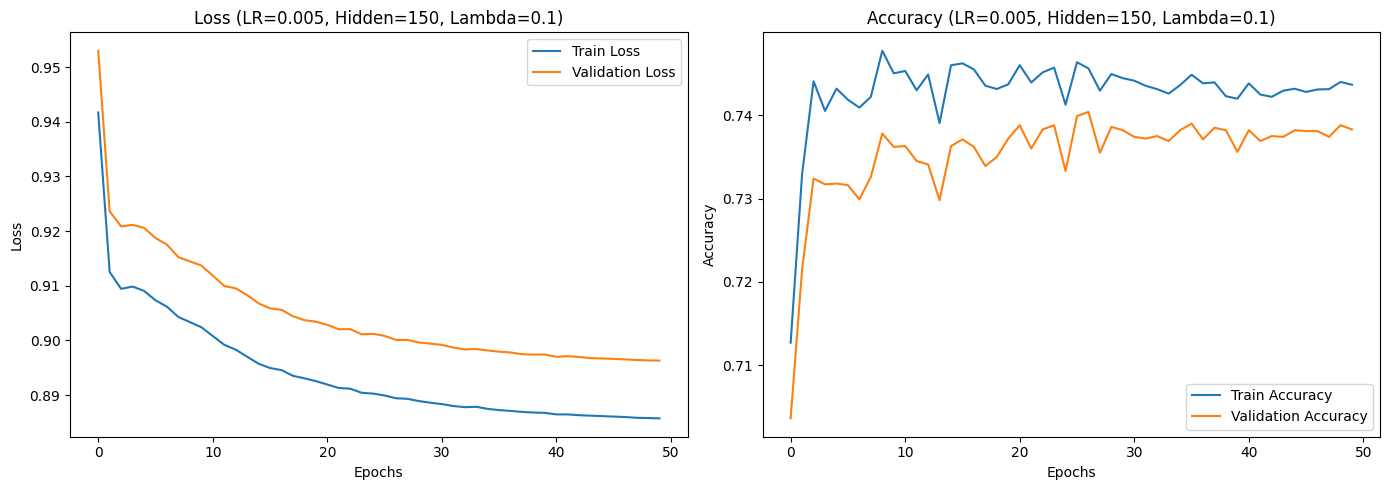

LR: 0.005, Hidden: 150, Lambda: 0.1, Best Val Acc: 0.7404
Epoch 1/50, Train Loss: 1.4177, Train Acc: 0.5951, Val Loss: 1.4276, Val Acc: 0.5936
Epoch 2/50, Train Loss: 1.0861, Train Acc: 0.6679, Val Loss: 1.1004, Val Acc: 0.6589
Epoch 3/50, Train Loss: 0.9416, Train Acc: 0.6994, Val Loss: 0.9582, Val Acc: 0.6878
Epoch 4/50, Train Loss: 0.8612, Train Acc: 0.7216, Val Loss: 0.8789, Val Acc: 0.7100
Epoch 5/50, Train Loss: 0.8093, Train Acc: 0.7388, Val Loss: 0.8280, Val Acc: 0.7233
Epoch 6/50, Train Loss: 0.7714, Train Acc: 0.7498, Val Loss: 0.7909, Val Acc: 0.7379
Epoch 7/50, Train Loss: 0.7425, Train Acc: 0.7594, Val Loss: 0.7627, Val Acc: 0.7443
Epoch 8/50, Train Loss: 0.7196, Train Acc: 0.7654, Val Loss: 0.7403, Val Acc: 0.7522
Epoch 9/50, Train Loss: 0.7011, Train Acc: 0.7722, Val Loss: 0.7224, Val Acc: 0.7578
Epoch 10/50, Train Loss: 0.6851, Train Acc: 0.7785, Val Loss: 0.7069, Val Acc: 0.7650
Epoch 11/50, Train Loss: 0.6721, Train Acc: 0.7821, Val Loss: 0.6941, Val Acc: 0.7689
Epoch

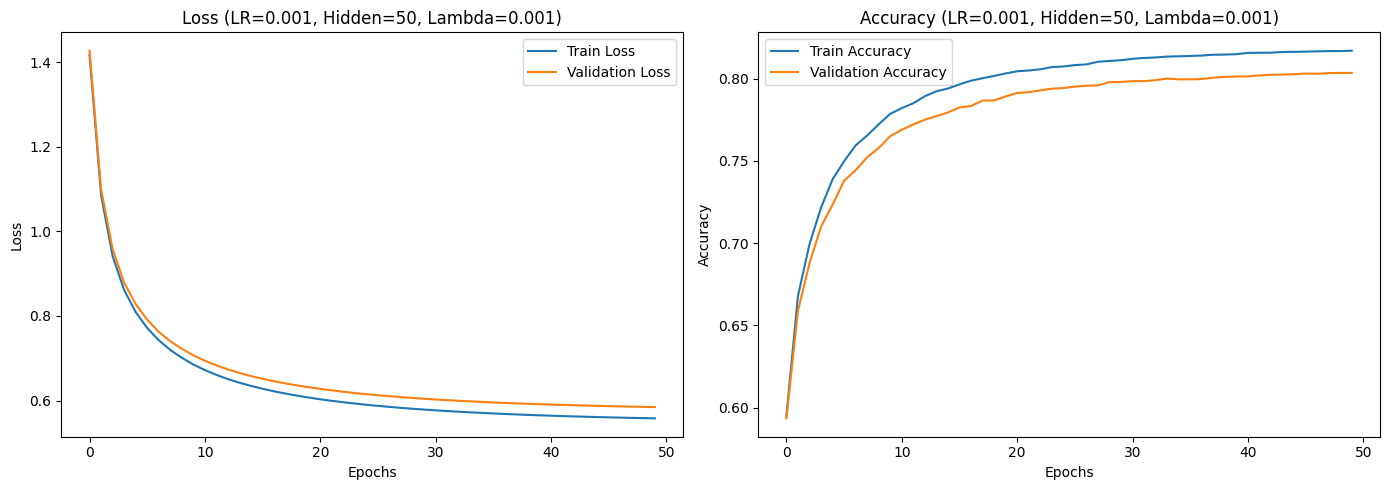

LR: 0.001, Hidden: 50, Lambda: 0.001, Best Val Acc: 0.8034
Epoch 1/50, Train Loss: 1.3862, Train Acc: 0.6017, Val Loss: 1.3939, Val Acc: 0.5910
Epoch 2/50, Train Loss: 1.0816, Train Acc: 0.6690, Val Loss: 1.0936, Val Acc: 0.6573
Epoch 3/50, Train Loss: 0.9504, Train Acc: 0.6974, Val Loss: 0.9645, Val Acc: 0.6846
Epoch 4/50, Train Loss: 0.8750, Train Acc: 0.7153, Val Loss: 0.8907, Val Acc: 0.7025
Epoch 5/50, Train Loss: 0.8254, Train Acc: 0.7340, Val Loss: 0.8423, Val Acc: 0.7210
Epoch 6/50, Train Loss: 0.7894, Train Acc: 0.7435, Val Loss: 0.8067, Val Acc: 0.7335
Epoch 7/50, Train Loss: 0.7620, Train Acc: 0.7544, Val Loss: 0.7803, Val Acc: 0.7404
Epoch 8/50, Train Loss: 0.7400, Train Acc: 0.7595, Val Loss: 0.7584, Val Acc: 0.7477
Epoch 9/50, Train Loss: 0.7222, Train Acc: 0.7693, Val Loss: 0.7413, Val Acc: 0.7560
Epoch 10/50, Train Loss: 0.7073, Train Acc: 0.7748, Val Loss: 0.7267, Val Acc: 0.7605
Epoch 11/50, Train Loss: 0.6949, Train Acc: 0.7771, Val Loss: 0.7145, Val Acc: 0.7632
Epoc

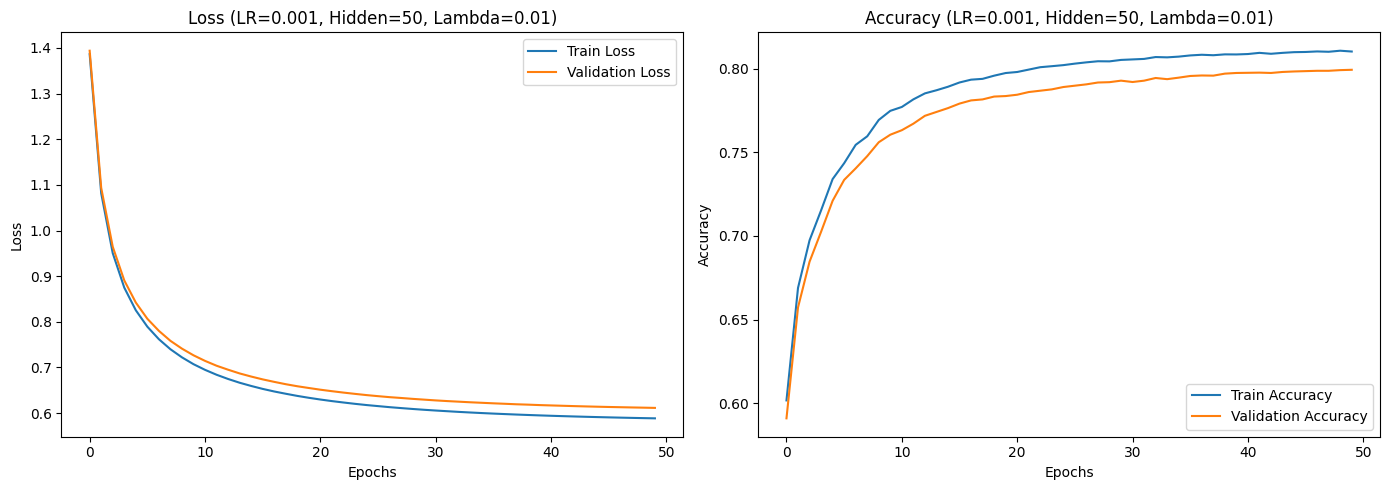

LR: 0.001, Hidden: 50, Lambda: 0.01, Best Val Acc: 0.7993
Epoch 1/50, Train Loss: 1.3858, Train Acc: 0.6313, Val Loss: 1.3919, Val Acc: 0.6310
Epoch 2/50, Train Loss: 1.1245, Train Acc: 0.6721, Val Loss: 1.1329, Val Acc: 0.6648
Epoch 3/50, Train Loss: 1.0261, Train Acc: 0.6911, Val Loss: 1.0359, Val Acc: 0.6826
Epoch 4/50, Train Loss: 0.9785, Train Acc: 0.6999, Val Loss: 0.9887, Val Acc: 0.6900
Epoch 5/50, Train Loss: 0.9522, Train Acc: 0.7070, Val Loss: 0.9628, Val Acc: 0.6962
Epoch 6/50, Train Loss: 0.9367, Train Acc: 0.7117, Val Loss: 0.9475, Val Acc: 0.7013
Epoch 7/50, Train Loss: 0.9273, Train Acc: 0.7164, Val Loss: 0.9385, Val Acc: 0.7044
Epoch 8/50, Train Loss: 0.9212, Train Acc: 0.7206, Val Loss: 0.9323, Val Acc: 0.7104
Epoch 9/50, Train Loss: 0.9176, Train Acc: 0.7238, Val Loss: 0.9288, Val Acc: 0.7153
Epoch 10/50, Train Loss: 0.9151, Train Acc: 0.7259, Val Loss: 0.9263, Val Acc: 0.7169
Epoch 11/50, Train Loss: 0.9136, Train Acc: 0.7257, Val Loss: 0.9250, Val Acc: 0.7123
Epoch

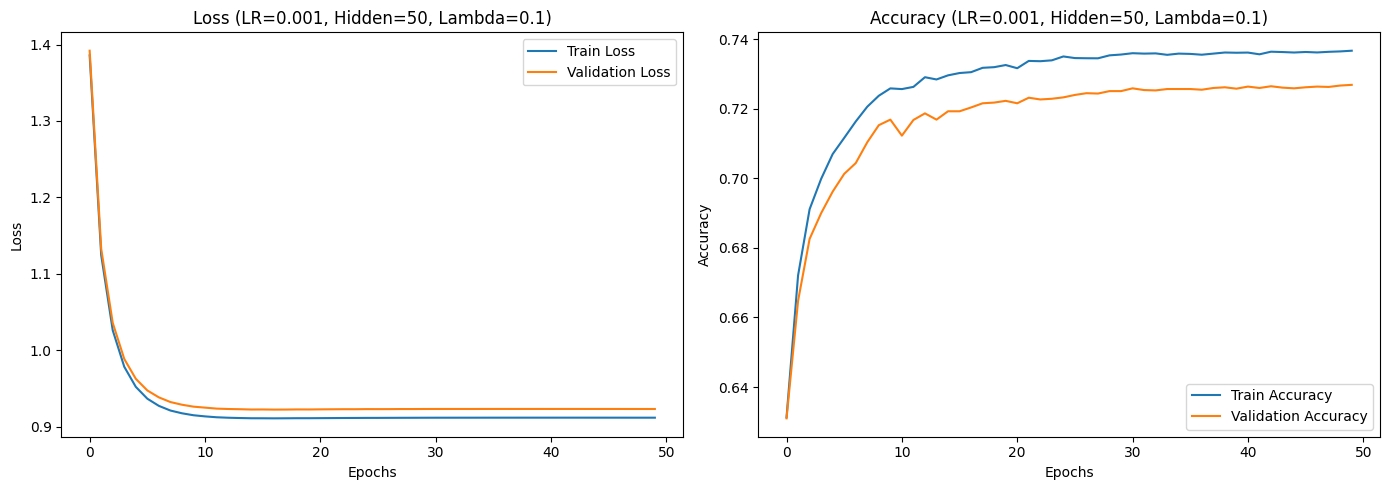

LR: 0.001, Hidden: 50, Lambda: 0.1, Best Val Acc: 0.7269
Epoch 1/50, Train Loss: 1.3669, Train Acc: 0.6493, Val Loss: 1.3707, Val Acc: 0.6476
Epoch 2/50, Train Loss: 1.0304, Train Acc: 0.7052, Val Loss: 1.0384, Val Acc: 0.6953
Epoch 3/50, Train Loss: 0.8923, Train Acc: 0.7272, Val Loss: 0.9033, Val Acc: 0.7175
Epoch 4/50, Train Loss: 0.8187, Train Acc: 0.7408, Val Loss: 0.8317, Val Acc: 0.7271
Epoch 5/50, Train Loss: 0.7715, Train Acc: 0.7538, Val Loss: 0.7860, Val Acc: 0.7402
Epoch 6/50, Train Loss: 0.7382, Train Acc: 0.7639, Val Loss: 0.7538, Val Acc: 0.7509
Epoch 7/50, Train Loss: 0.7130, Train Acc: 0.7716, Val Loss: 0.7294, Val Acc: 0.7583
Epoch 8/50, Train Loss: 0.6931, Train Acc: 0.7763, Val Loss: 0.7102, Val Acc: 0.7628
Epoch 9/50, Train Loss: 0.6765, Train Acc: 0.7817, Val Loss: 0.6944, Val Acc: 0.7684
Epoch 10/50, Train Loss: 0.6630, Train Acc: 0.7863, Val Loss: 0.6810, Val Acc: 0.7744
Epoch 11/50, Train Loss: 0.6515, Train Acc: 0.7896, Val Loss: 0.6701, Val Acc: 0.7781
Epoch 

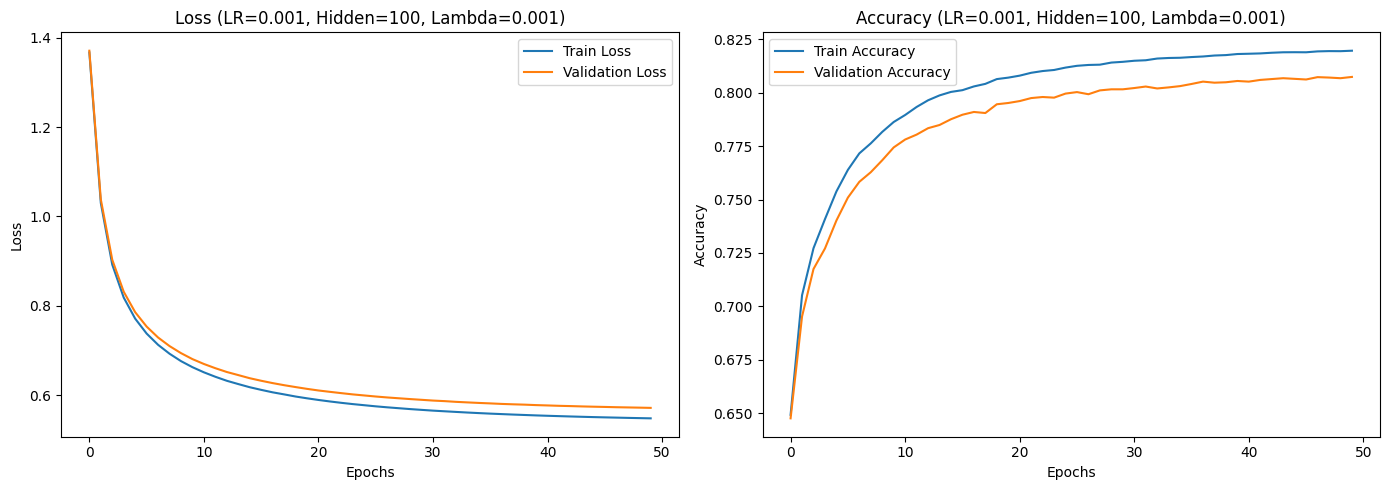

LR: 0.001, Hidden: 100, Lambda: 0.001, Best Val Acc: 0.8074
Epoch 1/50, Train Loss: 1.3336, Train Acc: 0.6141, Val Loss: 1.3416, Val Acc: 0.6085
Epoch 2/50, Train Loss: 1.0451, Train Acc: 0.6779, Val Loss: 1.0571, Val Acc: 0.6712
Epoch 3/50, Train Loss: 0.9216, Train Acc: 0.7080, Val Loss: 0.9353, Val Acc: 0.6979
Epoch 4/50, Train Loss: 0.8510, Train Acc: 0.7277, Val Loss: 0.8658, Val Acc: 0.7167
Epoch 5/50, Train Loss: 0.8043, Train Acc: 0.7427, Val Loss: 0.8197, Val Acc: 0.7308
Epoch 6/50, Train Loss: 0.7703, Train Acc: 0.7555, Val Loss: 0.7863, Val Acc: 0.7410
Epoch 7/50, Train Loss: 0.7443, Train Acc: 0.7632, Val Loss: 0.7610, Val Acc: 0.7479
Epoch 8/50, Train Loss: 0.7239, Train Acc: 0.7690, Val Loss: 0.7407, Val Acc: 0.7555
Epoch 9/50, Train Loss: 0.7069, Train Acc: 0.7740, Val Loss: 0.7241, Val Acc: 0.7606
Epoch 10/50, Train Loss: 0.6931, Train Acc: 0.7784, Val Loss: 0.7104, Val Acc: 0.7648
Epoch 11/50, Train Loss: 0.6813, Train Acc: 0.7824, Val Loss: 0.6992, Val Acc: 0.7678
Epo

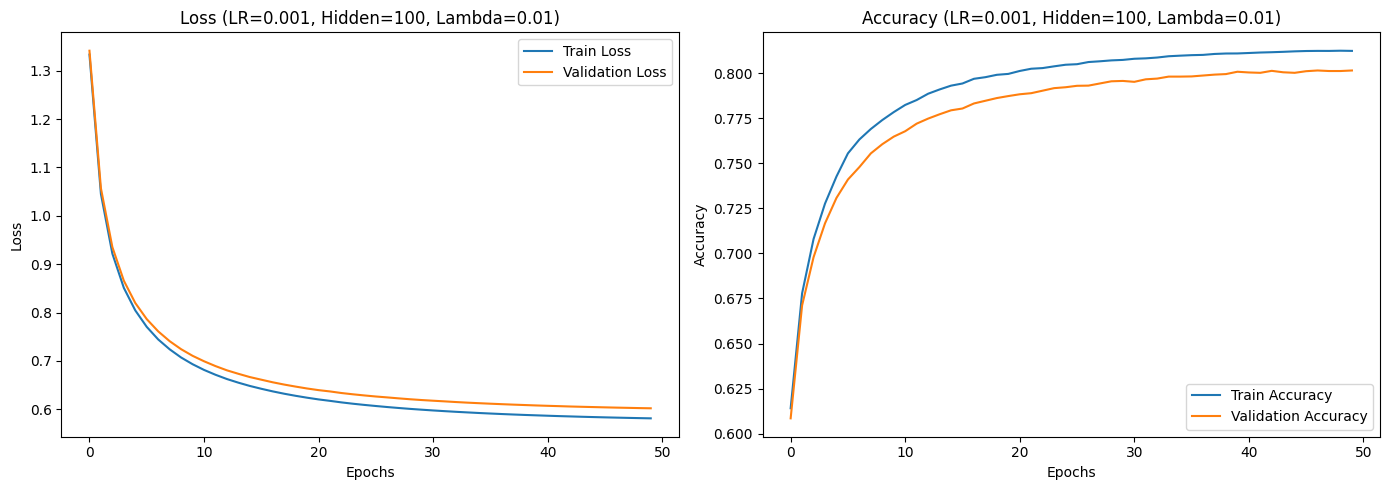

LR: 0.001, Hidden: 100, Lambda: 0.01, Best Val Acc: 0.8015
Epoch 1/50, Train Loss: 1.3790, Train Acc: 0.6289, Val Loss: 1.3866, Val Acc: 0.6240
Epoch 2/50, Train Loss: 1.1369, Train Acc: 0.6777, Val Loss: 1.1475, Val Acc: 0.6691
Epoch 3/50, Train Loss: 1.0416, Train Acc: 0.6926, Val Loss: 1.0536, Val Acc: 0.6823
Epoch 4/50, Train Loss: 0.9938, Train Acc: 0.7004, Val Loss: 1.0064, Val Acc: 0.6893
Epoch 5/50, Train Loss: 0.9665, Train Acc: 0.7088, Val Loss: 0.9798, Val Acc: 0.6962
Epoch 6/50, Train Loss: 0.9504, Train Acc: 0.7162, Val Loss: 0.9636, Val Acc: 0.7050
Epoch 7/50, Train Loss: 0.9398, Train Acc: 0.7198, Val Loss: 0.9532, Val Acc: 0.7072
Epoch 8/50, Train Loss: 0.9322, Train Acc: 0.7224, Val Loss: 0.9456, Val Acc: 0.7086
Epoch 9/50, Train Loss: 0.9273, Train Acc: 0.7259, Val Loss: 0.9406, Val Acc: 0.7118
Epoch 10/50, Train Loss: 0.9239, Train Acc: 0.7275, Val Loss: 0.9373, Val Acc: 0.7137
Epoch 11/50, Train Loss: 0.9213, Train Acc: 0.7298, Val Loss: 0.9346, Val Acc: 0.7146
Epoc

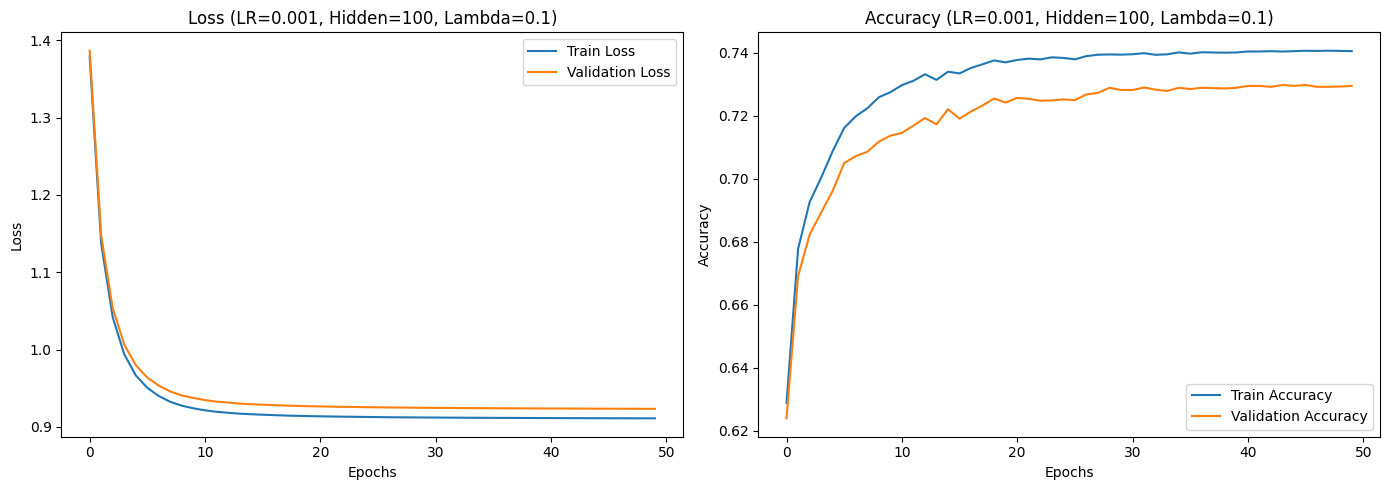

LR: 0.001, Hidden: 100, Lambda: 0.1, Best Val Acc: 0.7298
Epoch 1/50, Train Loss: 1.2214, Train Acc: 0.6589, Val Loss: 1.2325, Val Acc: 0.6519
Epoch 2/50, Train Loss: 0.9841, Train Acc: 0.6925, Val Loss: 0.9983, Val Acc: 0.6859
Epoch 3/50, Train Loss: 0.8805, Train Acc: 0.7132, Val Loss: 0.8961, Val Acc: 0.7056
Epoch 4/50, Train Loss: 0.8195, Train Acc: 0.7333, Val Loss: 0.8365, Val Acc: 0.7231
Epoch 5/50, Train Loss: 0.7770, Train Acc: 0.7469, Val Loss: 0.7945, Val Acc: 0.7357
Epoch 6/50, Train Loss: 0.7455, Train Acc: 0.7577, Val Loss: 0.7639, Val Acc: 0.7471
Epoch 7/50, Train Loss: 0.7215, Train Acc: 0.7673, Val Loss: 0.7405, Val Acc: 0.7535
Epoch 8/50, Train Loss: 0.7009, Train Acc: 0.7746, Val Loss: 0.7203, Val Acc: 0.7609
Epoch 9/50, Train Loss: 0.6843, Train Acc: 0.7800, Val Loss: 0.7038, Val Acc: 0.7660
Epoch 10/50, Train Loss: 0.6702, Train Acc: 0.7855, Val Loss: 0.6905, Val Acc: 0.7723
Epoch 11/50, Train Loss: 0.6582, Train Acc: 0.7894, Val Loss: 0.6787, Val Acc: 0.7757
Epoch

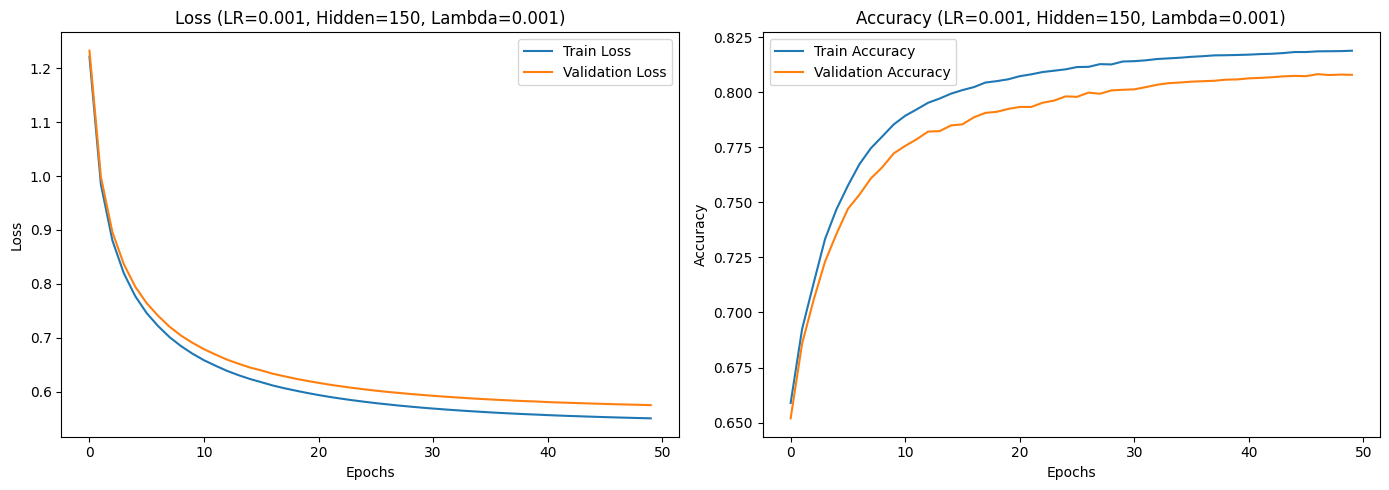

LR: 0.001, Hidden: 150, Lambda: 0.001, Best Val Acc: 0.8083
Epoch 1/50, Train Loss: 1.2557, Train Acc: 0.6438, Val Loss: 1.2654, Val Acc: 0.6380
Epoch 2/50, Train Loss: 1.0041, Train Acc: 0.6868, Val Loss: 1.0165, Val Acc: 0.6800
Epoch 3/50, Train Loss: 0.8942, Train Acc: 0.7100, Val Loss: 0.9083, Val Acc: 0.7004
Epoch 4/50, Train Loss: 0.8302, Train Acc: 0.7335, Val Loss: 0.8457, Val Acc: 0.7218
Epoch 5/50, Train Loss: 0.7871, Train Acc: 0.7462, Val Loss: 0.8038, Val Acc: 0.7335
Epoch 6/50, Train Loss: 0.7560, Train Acc: 0.7557, Val Loss: 0.7734, Val Acc: 0.7426
Epoch 7/50, Train Loss: 0.7322, Train Acc: 0.7638, Val Loss: 0.7501, Val Acc: 0.7490
Epoch 8/50, Train Loss: 0.7133, Train Acc: 0.7686, Val Loss: 0.7313, Val Acc: 0.7547
Epoch 9/50, Train Loss: 0.6974, Train Acc: 0.7754, Val Loss: 0.7162, Val Acc: 0.7595
Epoch 10/50, Train Loss: 0.6842, Train Acc: 0.7790, Val Loss: 0.7031, Val Acc: 0.7648
Epoch 11/50, Train Loss: 0.6731, Train Acc: 0.7836, Val Loss: 0.6926, Val Acc: 0.7691
Epo

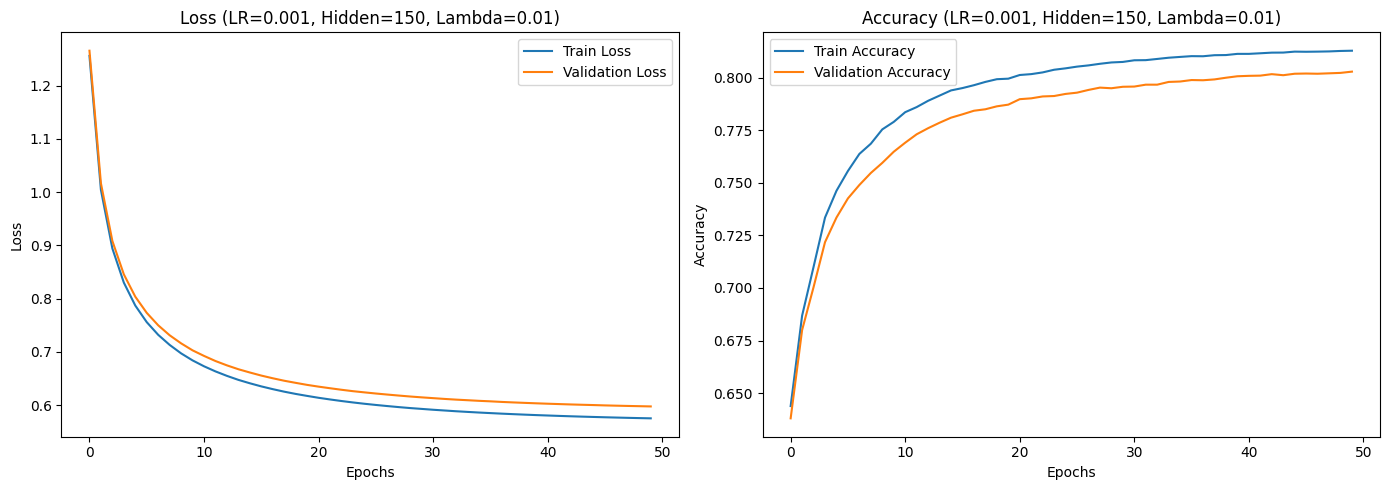

LR: 0.001, Hidden: 150, Lambda: 0.01, Best Val Acc: 0.8029
Epoch 1/50, Train Loss: 1.3725, Train Acc: 0.6315, Val Loss: 1.3801, Val Acc: 0.6303
Epoch 2/50, Train Loss: 1.1378, Train Acc: 0.6704, Val Loss: 1.1483, Val Acc: 0.6615
Epoch 3/50, Train Loss: 1.0446, Train Acc: 0.6862, Val Loss: 1.0568, Val Acc: 0.6754
Epoch 4/50, Train Loss: 0.9971, Train Acc: 0.6974, Val Loss: 1.0099, Val Acc: 0.6870
Epoch 5/50, Train Loss: 0.9693, Train Acc: 0.7053, Val Loss: 0.9824, Val Acc: 0.6937
Epoch 6/50, Train Loss: 0.9521, Train Acc: 0.7106, Val Loss: 0.9653, Val Acc: 0.6999
Epoch 7/50, Train Loss: 0.9408, Train Acc: 0.7172, Val Loss: 0.9538, Val Acc: 0.7051
Epoch 8/50, Train Loss: 0.9329, Train Acc: 0.7224, Val Loss: 0.9462, Val Acc: 0.7088
Epoch 9/50, Train Loss: 0.9275, Train Acc: 0.7225, Val Loss: 0.9408, Val Acc: 0.7111
Epoch 10/50, Train Loss: 0.9239, Train Acc: 0.7271, Val Loss: 0.9370, Val Acc: 0.7149
Epoch 11/50, Train Loss: 0.9210, Train Acc: 0.7272, Val Loss: 0.9343, Val Acc: 0.7158
Epoc

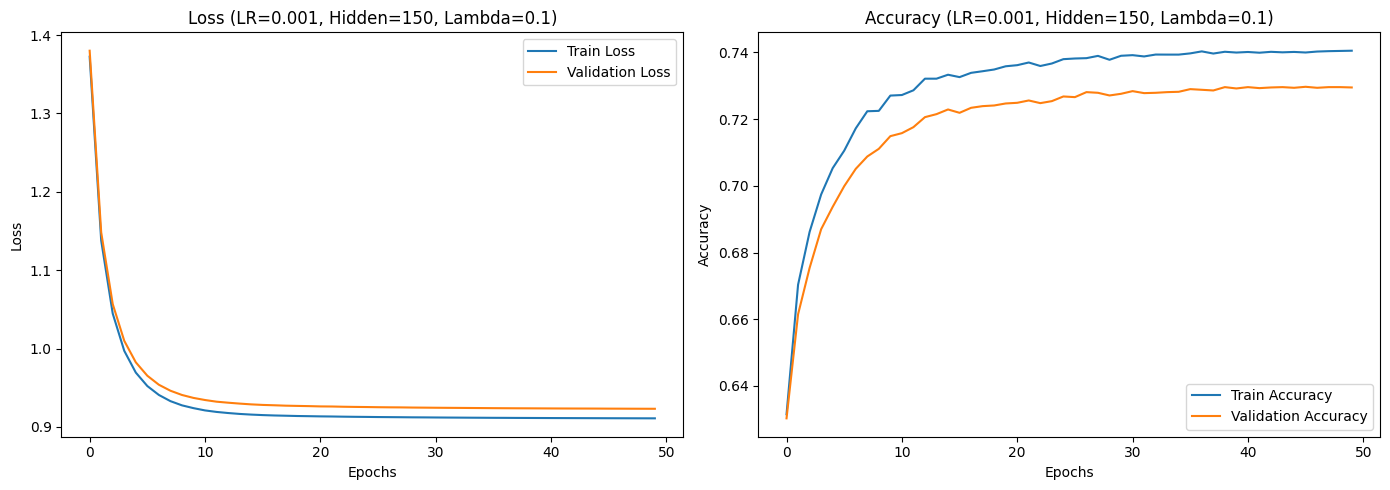

LR: 0.001, Hidden: 150, Lambda: 0.1, Best Val Acc: 0.7297


In [12]:
input_size = 784  # 28*28
hidden_size = 128
output_size = 10

learning_rates = [0.01, 0.005, 0.001]
hidden_sizes = [50, 100, 150]
lambdas = [0.001, 0.01, 0.1]

epochs = 50
batch_size = 64

best_overall_val_acc = 0
best_overall_params = {}
best_lr = 0
best_hidden_size = 0
best_lambda_reg = 0

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for lambda_reg in lambdas:
            model = NeuralNetwork(input_size, hidden_size, output_size)
            history = train(model, train_images, train_labels_one_hot, test_images, test_labels_one_hot, epochs, batch_size, lr, lambda_reg)
            plot_history_with_params(history, lr, hidden_size, lambda_reg)
            plt.close()
            current_val_acc = max(history['val_acc'])
            print(f"LR: {lr}, Hidden: {hidden_size}, Lambda: {lambda_reg}, Best Val Acc: {current_val_acc}")

            # 如果当前模型在验证集上的准确率高于迄今为止的最佳准确率
            if current_val_acc > best_overall_val_acc:
                best_overall_val_acc = current_val_acc
                best_overall_params = model.params.copy() # 保存最佳模型参数的拷贝
                best_lr = lr
                best_hidden_size = hidden_size
                best_lambda_reg = lambda_reg

#### 5.保存模型

In [13]:
# 保存最佳超参数和模型参数
np.save('best_model_params.npy', best_overall_params)
print(f"Best overall val acc: {best_overall_val_acc}")
print(f"Best learning rate: {best_lr}")
print(f"Best hidden layer size: {best_hidden_size}")
print(f"Best lambda reg: {best_lambda_reg}")

Best overall val acc: 0.8565
Best learning rate: 0.01
Best hidden layer size: 100
Best lambda reg: 0.001


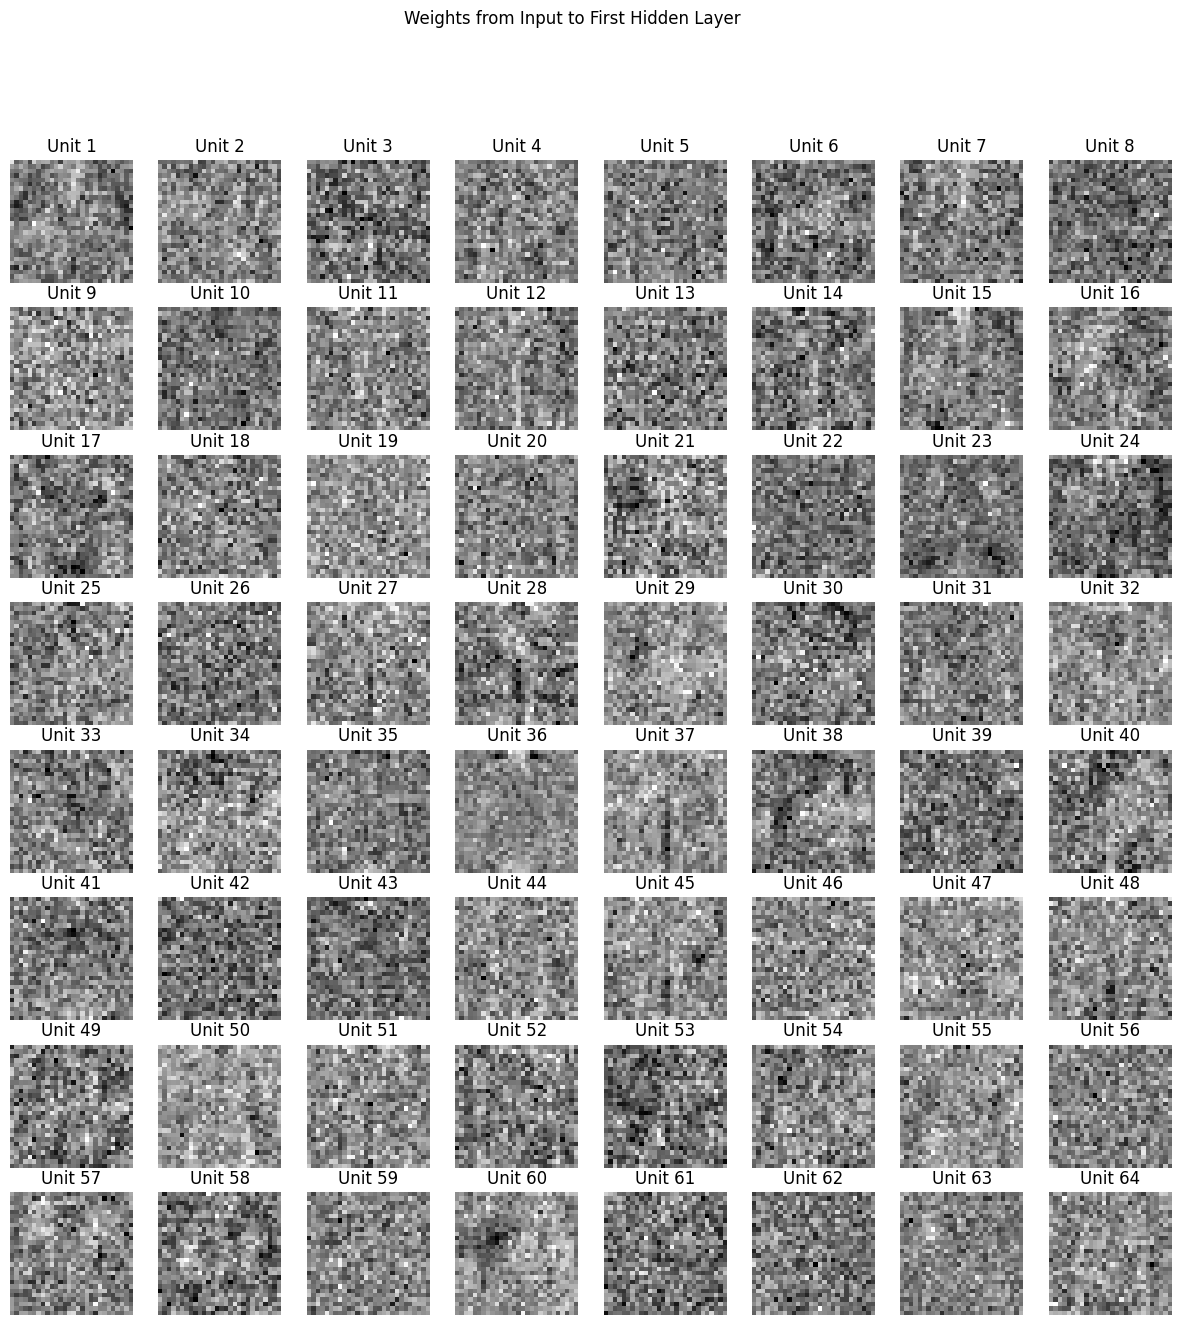

In [21]:
# 加载保存的最佳模型参数
best_params = np.load('best_model_params.npy', allow_pickle=True).item()

# 假设有一个函数来创建模型，我们需要定义模型的输入尺寸、隐藏层大小和输出尺寸
input_size = 784  # 对于28*28像素的图像
hidden_size = best_params['W1'].shape[1]  # 从权重维度推断隐藏层大小
output_size = 10  # 分类问题的类别数

# 初始化模型
model = NeuralNetwork(input_size, hidden_size, output_size)
model.params = best_params

# 可视化输入层到第一隐藏层的权重
visualize_weights(model.params['W1'], "Weights from Input to First Hidden Layer")